# Маркетинг

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

### Цель

Предсказать вероятность покупки в течение 90 дней

### Задачи

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## Данные

#### apparel-purchases 

история покупок  

- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки

#### apparel-messages  

история рекламных рассылок  

- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

#### apparel-target_binary  

совершит ли клиент покупку в течение следующих 90 дней  

- client_id идентификатор пользователя
- target целевой признак

## Подготовка данных

### Импорты

In [84]:
# Инсталляция требуемых пакетов и модулей
#!pip install seaborn==0.13.2 matplotlib==3.8.4 -q

# Загрузка стандартных модулей Python
import sys
import warnings
from time import perf_counter

# Подключение библиотек для анализа данных
import numpy as np
import pandas as pd

# Импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import shap

# Optuna
import optuna

# Scikit-learn - preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler

# Scikit-learn - model selection
from sklearn.model_selection import train_test_split, cross_val_score

# Scikit-learn - compose & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn - feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Scikit-learn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn - metrics & inspection
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# LightGBM
try:
    import lightgbm as lgb
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb

Задаем константные значения

In [85]:
TEST_SIZE=0.2
RANDOM_STATE=42
N_TRIALS=20
TOP_N=20
VIF_THRESHOLD=9.0

### Загрузим датасет
Загрузка данных из CSV файла

In [86]:
df_msg = pd.read_csv('apparel-messages.csv')
df_purchases = pd.read_csv('apparel-purchases.csv')
df_target = pd.read_csv('apparel-target_binary.csv')
df_event_type = pd.read_csv('full_campaign_daily_event_channel.csv')
df_event_channel = pd.read_csv('full_campaign_daily_event.csv')



## Анализ данных

Формируем словарь с наборами датасета, что бы потом этот словарь использовать

In [87]:
# Список всех датасетов
datasets = {
    'messages': df_msg,
    'purchases': df_purchases,
    'target': df_target,
    'event_type': df_event_type,
    'event_channel': df_event_channel
}


Выводим доступные датасеты
Получаем размер: количество строк, количество столбцов
Проверяем объем данных и не потеряли ли мы строки

In [88]:
print("Доступные датасеты:")
for name, dataset in datasets.items():
    print(f"- {name}: {dataset.shape[0]} строк, {dataset.shape[1]} столбцов")


Доступные датасеты:
- messages: 12739798 строк, 7 столбцов
- purchases: 202208 строк, 6 столбцов
- target: 49849 строк, 2 столбцов
- event_type: 131072 строк, 36 столбцов
- event_channel: 131072 строк, 24 столбцов


Создаем функцию вывода детальной информации о наших датасетах.
Входные параметры: словарь с датасетами, где ключ - название датасета, значение - DataFrame
Вывод будет первые 10 строк и общие данные датасета

In [89]:
def display_datasets_info(datasets_dict):
    for name, dataset in datasets_dict.items():
        print(f"\n{'='*60}")
        print(f"ДАТАСЕТ: {name.upper()}")
        print(f"{'='*60}")
        
        # Выводим первые 10 строк
        print(f"\nПервые 10 строк датасета '{name}':")
        display(dataset.head(10))
        
        # Выводим общую информацию
        print(f"\nОбщая информация о датасете '{name}':")

        dataset.info()
        
        print(f"\n{'='*60}\n")


In [90]:
# Используем функцию для вывода информации по всем датасетам
display_datasets_info(datasets)



ДАТАСЕТ: MESSAGES

Первые 10 строк датасета 'messages':


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06



Общая информация о датасете 'messages':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB



ДАТАСЕТ: PURCHASES

Первые 10 строк датасета 'purchases':


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2



Общая информация о датасете 'purchases':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB



ДАТАСЕТ: TARGET

Первые 10 строк датасета 'target':


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0



Общая информация о датасете 'target':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB



ДАТАСЕТ: EVENT_TYPE

Первые 10 строк датасета 'event_type':


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Общая информация о датасете 'event_type':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              13

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0



Общая информация о датасете 'event_channel':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  

Исходя из вывода информации по датасетам, можно сделать следующие выводы:

1. Для пердсказаний придется добавлять новые признаки  
2. Последние два датасета event_type и event_channel не несут полезной информации для исследования, непонятно как их использовать. В связи с этим уберем эти два датасета из нашего списка датасетов

In [91]:
# Переопределим датасеты
datasets = {
    'messages': df_msg,
    'purchases': df_purchases,
    'target': df_target
}
# Проверяем
print("Доступные датасеты:")
for name, dataset in datasets.items():
    print(f"- {name}: {dataset.shape[0]} строк, {dataset.shape[1]} столбцов")

Доступные датасеты:
- messages: 12739798 строк, 7 столбцов
- purchases: 202208 строк, 6 столбцов
- target: 49849 строк, 2 столбцов


Создаем функцию проверки наличия пропущенных значений и дублирующихся строк, на вход принимаем словарь датасетов.

In [92]:
def analyze_missing_and_duplicates(datasets_dict):
    print("="*80)
    print("АНАЛИЗ ПРОПУСКОВ И ДУБЛИКАТОВ")
    print("="*80)
    
    total_datasets = len(datasets_dict)
    processed_datasets = 0
    
    for name, dataset in datasets_dict.items():
        processed_datasets += 1
        print(f"\nДАТАСЕТ {processed_datasets}/{total_datasets}: {name.upper()}")
        print("-" * 50)
        
        # Общая информация
        total_rows = len(dataset)
        total_cols = len(dataset.columns)
        print(f"Размер датасета: {total_rows:,} строк × {total_cols} столбцов")
        
        # Анализ пропусков
        print(f"\nАНАЛИЗ ПРОПУСКОВ:")
        missing_data = dataset.isnull().sum()
        missing_percent = (missing_data / total_rows * 100).round(2)
        
        # Суммируем значения в каждой группе, получаем агрегированные данные по клиентам или периодам
        if missing_data.sum() == 0:
            print("Пропусков нет!")
        else:
            print("Найдены пропуски:")
            for col in missing_data.index:
                if missing_data[col] > 0:
                    print(f"  • {col}: {missing_data[col]:,} ({missing_percent[col]}%)")
        
        # Анализ дубликатов - всегда показываем детали
        print(f"\nАНАЛИЗ ДУБЛИКАТОВ:")
        duplicates_count = dataset.duplicated().sum()
        duplicates_percent = (duplicates_count / total_rows * 100).round(2)
        
        if duplicates_count == 0:
            print("Дубликатов нет!")
        else:
            print(f"Найдено дубликатов: {duplicates_count:,} ({duplicates_percent}%)")
        
        # Дубликаты по строкам (полные дубликаты)
        full_duplicates = dataset.duplicated(keep=False).sum()
        if full_duplicates > 0:
            print(f"  • Полных дубликатов (включая оригиналы): {full_duplicates:,}")
        else:
            print("  • Полных дубликатов: 0")
        
        print("-" * 50)
    
    print(f"\nОБРАБОТАНО ДАТАСЕТОВ: {processed_datasets}/{total_datasets}")
    print("="*80)


Применяем функцию для всех датасетов

In [93]:

analyze_missing_and_duplicates(datasets)


АНАЛИЗ ПРОПУСКОВ И ДУБЛИКАТОВ

ДАТАСЕТ 1/3: MESSAGES
--------------------------------------------------
Размер датасета: 12,739,798 строк × 7 столбцов

АНАЛИЗ ПРОПУСКОВ:
Пропусков нет!

АНАЛИЗ ДУБЛИКАТОВ:
Найдено дубликатов: 48,610 (0.38%)
  • Полных дубликатов (включая оригиналы): 94,519
--------------------------------------------------

ДАТАСЕТ 2/3: PURCHASES
--------------------------------------------------
Размер датасета: 202,208 строк × 6 столбцов

АНАЛИЗ ПРОПУСКОВ:
Пропусков нет!

АНАЛИЗ ДУБЛИКАТОВ:
Найдено дубликатов: 73,020 (36.11%)
  • Полных дубликатов (включая оригиналы): 131,683
--------------------------------------------------

ДАТАСЕТ 3/3: TARGET
--------------------------------------------------
Размер датасета: 49,849 строк × 2 столбцов

АНАЛИЗ ПРОПУСКОВ:
Пропусков нет!

АНАЛИЗ ДУБЛИКАТОВ:
Дубликатов нет!
  • Полных дубликатов: 0
--------------------------------------------------

ОБРАБОТАНО ДАТАСЕТОВ: 3/3


Удалим дубли только из первого датасета,так как во втором у нас есть ограничение по формату даты и дубли могут быть не дубли

Создаем функцию для удаления дубликатов из датасета

In [94]:
def remove_duplicates_from_dataset(dataset, show_details=True):

    original_rows = len(dataset)
    duplicates_count = dataset.duplicated().sum()
    
    print(f"Исходно: {original_rows:,} строк, дубликатов: {duplicates_count:,}")
    
    if duplicates_count > 0:
        cleaned_dataset = dataset.drop_duplicates()
        new_rows = len(cleaned_dataset)
        removed_rows = original_rows - new_rows
        
        print(f"Удалено: {removed_rows:,} строк ({removed_rows/original_rows*100:.1f}%)")
        print(f"Осталось: {new_rows:,} строк")
        
        if show_details:
            # Суммируем значения в каждой группе, получаем агрегированные данные по клиентам или периодам
            print(f"Дубликаты: {cleaned_dataset.duplicated().sum()}")
    else:
        cleaned_dataset = dataset.copy()
        print("Дубликатов не найдено")
    
    return cleaned_dataset

Создаем функцию для проверки уникальности значений в категориальных столбцах датафрейма

In [95]:
def analyze_unique_values(df, df_name="DataFrame"):

    print(f"Информация по датафрейму '{df_name}':\n")
    
    # Находим категориальные столбцы
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Проверяем, есть ли категориальные столбцы
    if not categorical_cols.empty:
        for col in categorical_cols:
            unique_vals = df[col].unique()
            print(f"Уникальные значения для столбца '{col}':")
            print(f"Количество уникальных значений: {len(unique_vals)}")
            print(f"Значения: {unique_vals}")
            print()  # Добавляем пустую строку для разделения
    else:
        print("В датафрейме нет категориальных столбцов (тип 'object')")
    
    print("-" * 50)  # Разделитель


In [96]:
# Вызов функции для df_msg
analyze_unique_values(df_msg, "df_msg")

Информация по датафрейму 'df_msg':

Уникальные значения для столбца 'message_id':
Количество уникальных значений: 9061667
Значения: ['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f' ...
 '1515915625490988866-14656-65ce97f929ca4'
 '1515915625617022616-14656-65ce97f9299fe'
 '1515915625491736359-14656-65ce97f92a3fd']

Уникальные значения для столбца 'event':
Количество уникальных значений: 11
Значения: ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']

Уникальные значения для столбца 'channel':
Количество уникальных значений: 2
Значения: ['email' 'mobile_push']

Уникальные значения для столбца 'date':
Количество уникальных значений: 638
Значения: ['2022-05-19' '2022-05-20' '2022-05-21' '2022-05-22' '2022-05-23'
 '2022-05-24' '2022-05-25' '2022-05-26' '2022-05-27' '2022-05-28'
 '2022-05-29' '2022-05-30' '2022-05-31' '2022-06-01' '2022-06-02'
 '20

In [97]:
# Удаляем дубликаты из датасета сообщений
df_msg = remove_duplicates_from_dataset(df_msg)

Исходно: 12,739,798 строк, дубликатов: 48,610
Удалено: 48,610 строк (0.4%)
Осталось: 12,691,188 строк
Дубликаты: 0


In [98]:
# Проверяем
df_msg.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Анализируем датафрейм df_purchases

In [99]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Создаем функцию для проверки пустых категорий в датасете

In [100]:
def check_empty_categories(dataset, category_column="category_ids", show_details=True):

    total_rows = len(dataset)
    
    # Проверяем NaN значения
    nan_count = dataset[category_column].isnull().sum()
    
    # Проверяем пустые списки
    empty_lists_count = 0
    empty_strings_count = 0
    
    if category_column in dataset.columns:
        for idx, value in dataset[category_column].items():
            if pd.isna(value):
                continue
            elif isinstance(value, str):
                if value.strip() == '' or value == '[]':
                    empty_strings_count += 1
            elif isinstance(value, list):
                if len(value) == 0:
                    empty_lists_count += 1
    
    total_empty = nan_count + empty_lists_count + empty_strings_count
    empty_percent = (total_empty / total_rows * 100).round(2) if total_rows > 0 else 0
    
    print(f"Всего строк: {total_rows:,}")
    print(f"Пустых категорий: {total_empty:,} ({empty_percent}%)")
    
    if show_details and total_empty > 0:
        print(f"  NaN значения: {nan_count:,}")
        print(f"  Пустые списки: {empty_lists_count:,}")
        print(f"  Пустые строки: {empty_strings_count:,}")
        
        # Показываем примеры пустых категорий
        if total_empty > 0:
            print(f"\nПримеры пустых категорий:")
            empty_examples = dataset[
                dataset[category_column].isnull() | 
                # Преобразуем тип данных столбца (string -> datetime -> int и т.д.)
                (dataset[category_column].astype(str).str.strip() == '') |
                (dataset[category_column].astype(str) == '[]')
            # Показываем первые N строк датасета - для визуальной проверки структуры
            ].head(3)
            print(empty_examples[['client_id', category_column]].to_string(index=False))
    
    return {
        'total_rows': total_rows,
        'empty_categories': total_empty,
        'empty_percent': empty_percent,
        'nan_count': nan_count,
        'empty_lists_count': empty_lists_count,
        'empty_strings_count': empty_strings_count
    }

Применяем функцию

In [101]:
result = check_empty_categories(df_purchases, "category_ids")

Всего строк: 202,208
Пустых категорий: 5,579 (2.76%)
  NaN значения: 0
  Пустые списки: 0
  Пустые строки: 5,579

Примеры пустых категорий:
          client_id category_ids
1515915625558323436           []
1515915625558323436           []
1515915625474537721           []


Сравним отношение client_id в датасетах
Создадим функцию проверки отношения количества уникальных client_id из df_purchases к df_msg

In [102]:
def check_client_id_ratio(df_purchases, df_msg):

    # Получаем уникальные client_id из каждого датасета
    unique_purchases = df_purchases['client_id'].nunique()
    unique_messages = df_msg['client_id'].nunique()
    
    # Вычисляем отношение
    ratio = unique_purchases / unique_messages if unique_messages > 0 else 0
    
    print("="*60)
    print("АНАЛИЗ ОТНОШЕНИЯ УНИКАЛЬНЫХ CLIENT_ID")
    print("="*60)
    print(f"Уникальных client_id в df_purchases: {unique_purchases:,}")
    print(f"Уникальных client_id в df_msg: {unique_messages:,}")
    print(f"Отношение df_purchases/df_msg: {ratio:.4f}")
    
    if ratio > 1:
        print(f"→ В df_purchases на {((ratio - 1) * 100):.2f}% больше уникальных клиентов")
    elif ratio < 1:
        print(f"→ В df_msg на {((1 - ratio) * 100):.2f}% больше уникальных клиентов")
    else:
        print("→ Количество уникальных клиентов одинаково")
    
    return {
        'unique_purchases': unique_purchases,
        'unique_messages': unique_messages,
        'ratio': ratio
    }

Применяем функцию

In [103]:
# Анализ отношения количества уникальных client_id
ratio_result = check_client_id_ratio(df_purchases, df_msg)

АНАЛИЗ ОТНОШЕНИЯ УНИКАЛЬНЫХ CLIENT_ID
Уникальных client_id в df_purchases: 49,849
Уникальных client_id в df_msg: 53,329
Отношение df_purchases/df_msg: 0.9347
→ В df_msg на 6.53% больше уникальных клиентов


Создаем функцию проверяющую сколько есть client_id в df_purchases, которых нет в df_msg

In [104]:
def check_missing_clients_in_messages(df_purchases, df_msg):

    # Получаем множества уникальных client_id
    purchases_clients = set(df_purchases['client_id'].unique())
    messages_clients = set(df_msg['client_id'].unique())
    
    # Находим клиентов из purchases, которых нет в messages
    missing_in_messages = purchases_clients - messages_clients
    
    # Находим пересечение
    common_clients = purchases_clients & messages_clients
    
    # Вычисляем проценты
    total_purchases = len(purchases_clients)
    missing_count = len(missing_in_messages)
    common_count = len(common_clients)
    
    missing_percent = (missing_count / total_purchases * 100) if total_purchases > 0 else 0
    common_percent = (common_count / total_purchases * 100) if total_purchases > 0 else 0
    
    print("="*60)
    print("АНАЛИЗ ОТСУТСТВУЮЩИХ CLIENT_ID В СООБЩЕНИЯХ")
    print("="*60)
    print(f"Всего уникальных client_id в df_purchases: {total_purchases:,}")
    print(f"Есть в df_msg: {common_count:,} ({common_percent:.2f}%)")
    print(f"НЕТ в df_msg: {missing_count:,} ({missing_percent:.2f}%)")
    
    if missing_count > 0:
        print(f"\n→ {missing_percent:.2f}% клиентов с покупками не получали сообщения")
        
        # Показываем примеры отсутствующих клиентов
        print(f"\nПримеры client_id из purchases, которых нет в messages:")
        example_missing = list(missing_in_messages)[:5]
        for i, client_id in enumerate(example_missing, 1):
            print(f"  {i}. {client_id}")
        
        if len(example_missing) < missing_count:
            print(f"  ... и еще {missing_count - len(example_missing):,} клиентов")
    else:
        print("\n→ Все клиенты с покупками есть в сообщениях!")
    
    return {
        'total_purchases_clients': total_purchases,
        'common_clients': common_count,
        'missing_in_messages': missing_count,
        'missing_percent': missing_percent,
        'common_percent': common_percent,
        'missing_clients_list': list(missing_in_messages)
    }

Применяем функцию

In [105]:
# Анализ отсутствующих client_id в сообщениях
missing_result = check_missing_clients_in_messages(df_purchases, df_msg)

АНАЛИЗ ОТСУТСТВУЮЩИХ CLIENT_ID В СООБЩЕНИЯХ
Всего уникальных client_id в df_purchases: 49,849
Есть в df_msg: 41,982 (84.22%)
НЕТ в df_msg: 7,867 (15.78%)

→ 15.78% клиентов с покупками не получали сообщения

Примеры client_id из purchases, которых нет в messages:
  1. 1515915625490153481
  2. 1515915625599696908
  3. 1515915625637642257
  4. 1515915625648816147
  5. 1515915625588621334
  ... и еще 7,862 клиентов


Создаем функцию для проверки количества строк, где quantity == 0

In [106]:
def check_zero_quantity(df_purchases):

    total_rows = len(df_purchases)
    zero_quantity_rows = len(df_purchases[df_purchases['quantity'] == 0])
    zero_quantity_percent = (zero_quantity_rows / total_rows * 100) if total_rows > 0 else 0
    
    print("="*60)
    print("АНАЛИЗ СТРОК С quantity == 0")
    print("="*60)
    print(f"Всего строк в датасете: {total_rows:,}")
    print(f"Строк с quantity == 0: {zero_quantity_rows:,}")
    print(f"Процент строк с quantity == 0: {zero_quantity_percent:.2f}%")
    
    if zero_quantity_rows > 0:
        print(f"\n→ Найдено {zero_quantity_rows:,} строк с нулевым количеством товаров")
        
        # Показываем примеры строк с нулевым quantity
        print(f"\nПримеры строк с quantity == 0:")
        zero_quantity_examples = df_purchases[df_purchases['quantity'] == 0].head(5)
        print(zero_quantity_examples[['client_id', 'quantity', 'price', 'date']].to_string(index=False))
        
        if zero_quantity_rows > 5:
            print(f"... и еще {zero_quantity_rows - 5:,} строк")
    else:
        print("\n→ Строк с нулевым количеством товаров не найдено!")
    
    return {
        'total_rows': total_rows,
        'zero_quantity_rows': zero_quantity_rows,
        'zero_quantity_percent': zero_quantity_percent
    }

Применяем функцию

In [107]:
# Проверка строк с quantity == 0
quantity_result = check_zero_quantity(df_purchases)

АНАЛИЗ СТРОК С quantity == 0
Всего строк в датасете: 202,208
Строк с quantity == 0: 0
Процент строк с quantity == 0: 0.00%

→ Строк с нулевым количеством товаров не найдено!


Создаем функцию проверки наличия строк, где price == 0

In [108]:
def check_zero_price(df_purchases):

    total_rows = len(df_purchases)
    zero_price_rows = len(df_purchases[df_purchases['price'] == 0])
    zero_price_percent = (zero_price_rows / total_rows * 100) if total_rows > 0 else 0
    
    print("="*60)
    print("АНАЛИЗ СТРОК С price == 0")
    print("="*60)
    print(f"Всего строк в датасете: {total_rows:,}")
    print(f"Строк с price == 0: {zero_price_rows:,}")
    print(f"Процент строк с price == 0: {zero_price_percent:.2f}%")
    
    if zero_price_rows > 0:
        print(f"\n→ Найдено {zero_price_rows:,} строк с нулевой ценой")
        
        # Показываем примеры строк с нулевой ценой
        print(f"\nПримеры строк с price == 0:")
        zero_price_examples = df_purchases[df_purchases['price'] == 0].head(5)
        print(zero_price_examples[['client_id', 'quantity', 'price', 'date']].to_string(index=False))
        
        if zero_price_rows > 5:
            print(f"... и еще {zero_price_rows - 5:,} строк")
    else:
        print("\n→ Строк с нулевой ценой не найдено!")
    
    return {
        'total_rows': total_rows,
        'zero_price_rows': zero_price_rows,
        'zero_price_percent': zero_price_percent
    }

Применяем функцию

In [109]:
# Проверка строк с price == 0
price_result = check_zero_price(df_purchases)

АНАЛИЗ СТРОК С price == 0
Всего строк в датасете: 202,208
Строк с price == 0: 0
Процент строк с price == 0: 0.00%

→ Строк с нулевой ценой не найдено!


Проведем дополнительное исследование для датасета с покупками по числовым слобцам

Создаем функцию для создания гистограммы для всех числовых переменных в одном датасете

In [110]:
def visualize_single_dataset_numeric(df, dataset_name="Dataset", exclude_cols=None):

    # Настройка стиля графиков
    plt.rcParams['figure.facecolor'] = 'white'
    
    # Устанавливаем столбцы для исключения по умолчанию
    if exclude_cols is None:
        exclude_cols = ['id']
    
    # Получаем числовые столбцы, исключая указанные столбцы
    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']) 
                   if col not in exclude_cols]
    
    if not numeric_cols:
        print(f"В датафрейме {dataset_name} нет числовых столбцов для визуализации")
        return
    
    print(f"Визуализация числовых переменных для датафрейма: {dataset_name}")
    
    # Рассчитываем оптимальное количество строк и столбцов для subplot
    n_cols = 3
    n_rows = (len(numeric_cols) // n_cols + 1)
    
    # Создаем фигуру с динамическим размером
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle(f'Распределение числовых переменных: {dataset_name}', y=1.02, fontsize=14)
    
    # Выравниваем axes в плоский массив
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        # Строим гистограмму
        axes[i].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        
        # Настройка оформления
        axes[i].set_title(col, pad=10)
        axes[i].set_xlabel('Значения', fontsize=9)
        axes[i].set_ylabel('Частота', fontsize=9)
        axes[i].grid(axis='y', alpha=0.4)
    
    # Скрываем пустые subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Применяем функцию

Визуализация числовых переменных для датафрейма: Purchases


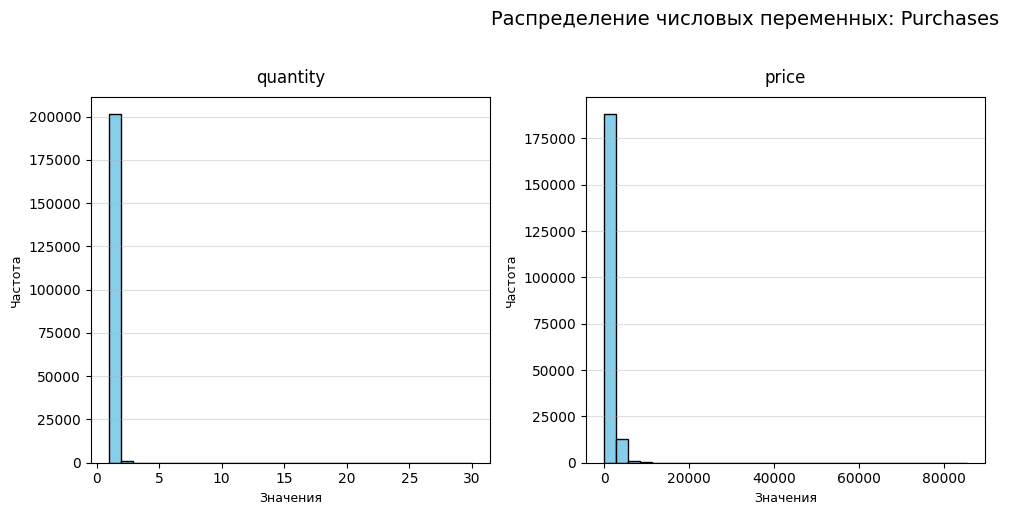

In [111]:
# Визуализация датасета покупок
visualize_single_dataset_numeric(df_purchases, "Purchases", exclude_cols=['client_id'])

Создаем функцию boxplot для всех числовых переменных в одном датасете

In [112]:
def visualize_single_dataset_boxplot(df, dataset_name="Dataset", exclude_cols=None):
 
    # Устанавливаем столбцы для исключения по умолчанию
    if exclude_cols is None:
        exclude_cols = ['id']
    
    # Получаем числовые столбцы, исключая указанные столбцы
    numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']) 
                   if col not in exclude_cols]
    
    if not numeric_cols:
        print(f"Нет числовых столбцов в датафрейме {dataset_name}")
        return
    
    # Рассчитываем количество строк и столбцов
    n_cols = 3
    n_rows = (len(numeric_cols) // n_cols) + 1
    
    # Создаем фигуру
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    fig.suptitle(f'Boxplot анализа: {dataset_name}', y=1.02, fontsize=14)
    
    # Обработка осей
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]  # если только один график
    
    for i, col in enumerate(numeric_cols):
        # Строим boxplot
        boxplot = axes[i].boxplot(df[col].dropna(),
                                patch_artist=True,
                                boxprops={'facecolor': 'skyblue', 'color': 'black'},
                                whiskerprops={'color': 'black'},
                                capprops={'color': 'black'},
                                medianprops={'color': 'red', 'linewidth': 2},
                                flierprops={'marker': 'o', 'markersize': 5})
        
        # Настройка оформления
        axes[i].set_title(col, fontsize=12)
        axes[i].set_ylabel('Значения', fontsize=10)
        axes[i].grid(axis='y', alpha=0.3)
    
    # Скрываем пустые subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Применяем функцию

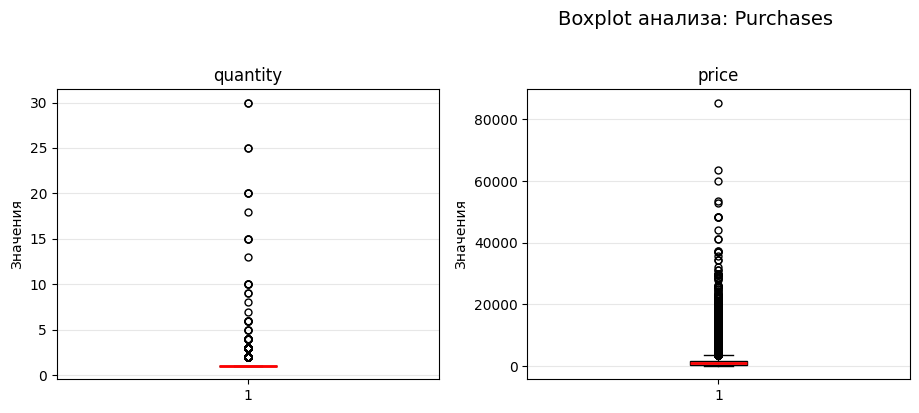

In [113]:
# Boxplot анализ датасета покупок
visualize_single_dataset_boxplot(df_purchases, "Purchases", exclude_cols=['client_id'])

Вывод:  
Провели анализ. Оставили 3 датасета с которыми будем работать. В одном из них удалили дубликаты.

## Предобработка данных

Попробуем сформировать новые признаки из текущих таблиц, которые нам покажут на привычки пользователей

Функция преобразования столбцов с датами в datetime

In [114]:
def convert_dates_simple(df, date_columns=None):

    df_copy = df.copy()
    
    if date_columns is None:
        # Автоматически находим столбцы с датами
        date_columns = [col for col in df_copy.columns 
                       if any(keyword in col.lower() for keyword in ['date', 'time', 'created', 'updated'])]
    
    for col in date_columns:
        if col in df_copy.columns:
            df_copy[col] = pd.to_datetime(df_copy[col], errors="coerce")
    
    return df_copy

Применяем функции

In [115]:
df_msg = convert_dates_simple(df_msg, ['date', 'created_at'])
df_purchases = convert_dates_simple(df_purchases, ['date'])

Выводим полную информацию о структуре датасета

In [116]:
df_msg.info()
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   messag

Посмотрим периоды покупок и рассылок

In [117]:
# Покупки
df_purchases['date'].min(), df_purchases['date'].max()


(Timestamp('2022-05-16 00:00:00'), Timestamp('2024-02-16 00:00:00'))

In [118]:
# Рассылки
df_msg['date'].min(), df_msg['date'].max()

(Timestamp('2022-05-19 00:00:00'), Timestamp('2024-02-15 00:00:00'))

Функция рассчета периода между первой и последней покупкой для каждого клиента

In [119]:
def calculate_purchase_period(df_purchases):

    # Группируем по client_id и находим первую и последнюю дату покупки
    purchase_periods = df_purchases.groupby('client_id')['date'].agg([
        'min',  # первая покупка
        'max',  # последняя покупка
        'count' # количество покупок
    ]).reset_index()
    
    # Переименовываем столбцы
    purchase_periods.columns = ['client_id', 'first_purchase', 'last_purchase', 'purchase_count']
    
    # Рассчитываем период в днях
    purchase_periods['purchase_period_days'] = (
        purchase_periods['last_purchase'] - purchase_periods['first_purchase']
    ).dt.days
    
    # Рассчитываем период в месяцах
    purchase_periods['purchase_period_months'] = (
        purchase_periods['purchase_period_days'] / 30.44
    ).round(2)
    
    return purchase_periods

Функция для анализа статистики периодов покупок

In [120]:
def analyze_purchase_periods(purchase_periods):

    print("="*60)
    print("АНАЛИЗ ПЕРИОДОВ ПОКУПОК")
    print("="*60)
    
    # Общая статистика
    total_clients = len(purchase_periods)
    clients_with_multiple_purchases = len(purchase_periods[purchase_periods['purchase_count'] > 1])
    
    print(f"Всего клиентов: {total_clients:,}")
    print(f"Клиентов с несколькими покупками: {clients_with_multiple_purchases:,}")
    print(f"Процент клиентов с повторными покупками: {(clients_with_multiple_purchases/total_clients*100):.2f}%")
    
    # Статистика по периодам (только для клиентов с несколькими покупками)
    multiple_purchases = purchase_periods[purchase_periods['purchase_count'] > 1]
    
    if len(multiple_purchases) > 0:
        print(f"\nСтатистика периодов покупок (клиенты с >1 покупкой):")
        print(f"Минимальный период: {multiple_purchases['purchase_period_days'].min()} дней")
        print(f"Максимальный период: {multiple_purchases['purchase_period_days'].max()} дней")
        print(f"Средний период: {multiple_purchases['purchase_period_days'].mean():.1f} дней")
        print(f"Медианный период: {multiple_purchases['purchase_period_days'].median():.1f} дней")
        
        # Распределение по периодам
        print(f"\nРаспределение периодов покупок:")
        print(f"До 30 дней: {len(multiple_purchases[multiple_purchases['purchase_period_days'] <= 30]):,} клиентов")
        print(f"30-90 дней: {len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 30) & (multiple_purchases['purchase_period_days'] <= 90)]):,} клиентов")
        print(f"90-180 дней: {len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 90) & (multiple_purchases['purchase_period_days'] <= 180)]):,} клиентов")
        print(f"180-365 дней: {len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 180) & (multiple_purchases['purchase_period_days'] <= 365)]):,} клиентов")
        print(f"Более 365 дней: {len(multiple_purchases[multiple_purchases['purchase_period_days'] > 365]):,} клиентов")
    
    return multiple_purchases

Функция для визуализации периодов покупок

In [121]:
def visualize_purchase_periods(purchase_periods):

    # Фильтруем только клиентов с несколькими покупками
    multiple_purchases = purchase_periods[purchase_periods['purchase_count'] > 1]
    
    if len(multiple_purchases) == 0:
        print("Нет клиентов с несколькими покупками для визуализации")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Анализ периодов покупок', fontsize=16)
    
    # 1. Гистограмма периодов покупок (дни)
    axes[0, 0].hist(multiple_purchases['purchase_period_days'], bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Распределение периодов покупок (дни)')
    axes[0, 0].set_xlabel('Дни между первой и последней покупкой')
    axes[0, 0].set_ylabel('Количество клиентов')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Boxplot периодов покупок
    axes[0, 1].boxplot(multiple_purchases['purchase_period_days'], patch_artist=True,
                      boxprops={'facecolor': 'lightgreen', 'color': 'black'})
    axes[0, 1].set_title('Boxplot периодов покупок')
    axes[0, 1].set_ylabel('Дни между покупками')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Распределение по периодам (столбчатая диаграмма)
    period_ranges = ['≤30 дней', '30-90 дней', '90-180 дней', '180-365 дней', '>365 дней']
    period_counts = [
        len(multiple_purchases[multiple_purchases['purchase_period_days'] <= 30]),
        len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 30) & (multiple_purchases['purchase_period_days'] <= 90)]),
        len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 90) & (multiple_purchases['purchase_period_days'] <= 180)]),
        len(multiple_purchases[(multiple_purchases['purchase_period_days'] > 180) & (multiple_purchases['purchase_period_days'] <= 365)]),
        len(multiple_purchases[multiple_purchases['purchase_period_days'] > 365])
    ]
    
    axes[1, 0].bar(period_ranges, period_counts, color='orange', edgecolor='black')
    axes[1, 0].set_title('Распределение клиентов по периодам покупок')
    axes[1, 0].set_ylabel('Количество клиентов')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Связь между количеством покупок и периодом
    axes[1, 1].scatter(multiple_purchases['purchase_count'], multiple_purchases['purchase_period_days'], 
                      alpha=0.6, color='red')
    axes[1, 1].set_title('Связь количества покупок и периода')
    axes[1, 1].set_xlabel('Количество покупок')
    axes[1, 1].set_ylabel('Период покупок (дни)')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Применяем функцию

АНАЛИЗ ПЕРИОДОВ ПОКУПОК
Всего клиентов: 49,849
Клиентов с несколькими покупками: 36,654
Процент клиентов с повторными покупками: 73.53%

Статистика периодов покупок (клиенты с >1 покупкой):
Минимальный период: 0 дней
Максимальный период: 636 дней
Средний период: 28.7 дней
Медианный период: 0.0 дней

Распределение периодов покупок:
До 30 дней: 31,789 клиентов
30-90 дней: 1,189 клиентов
90-180 дней: 1,213 клиентов
180-365 дней: 1,717 клиентов
Более 365 дней: 746 клиентов


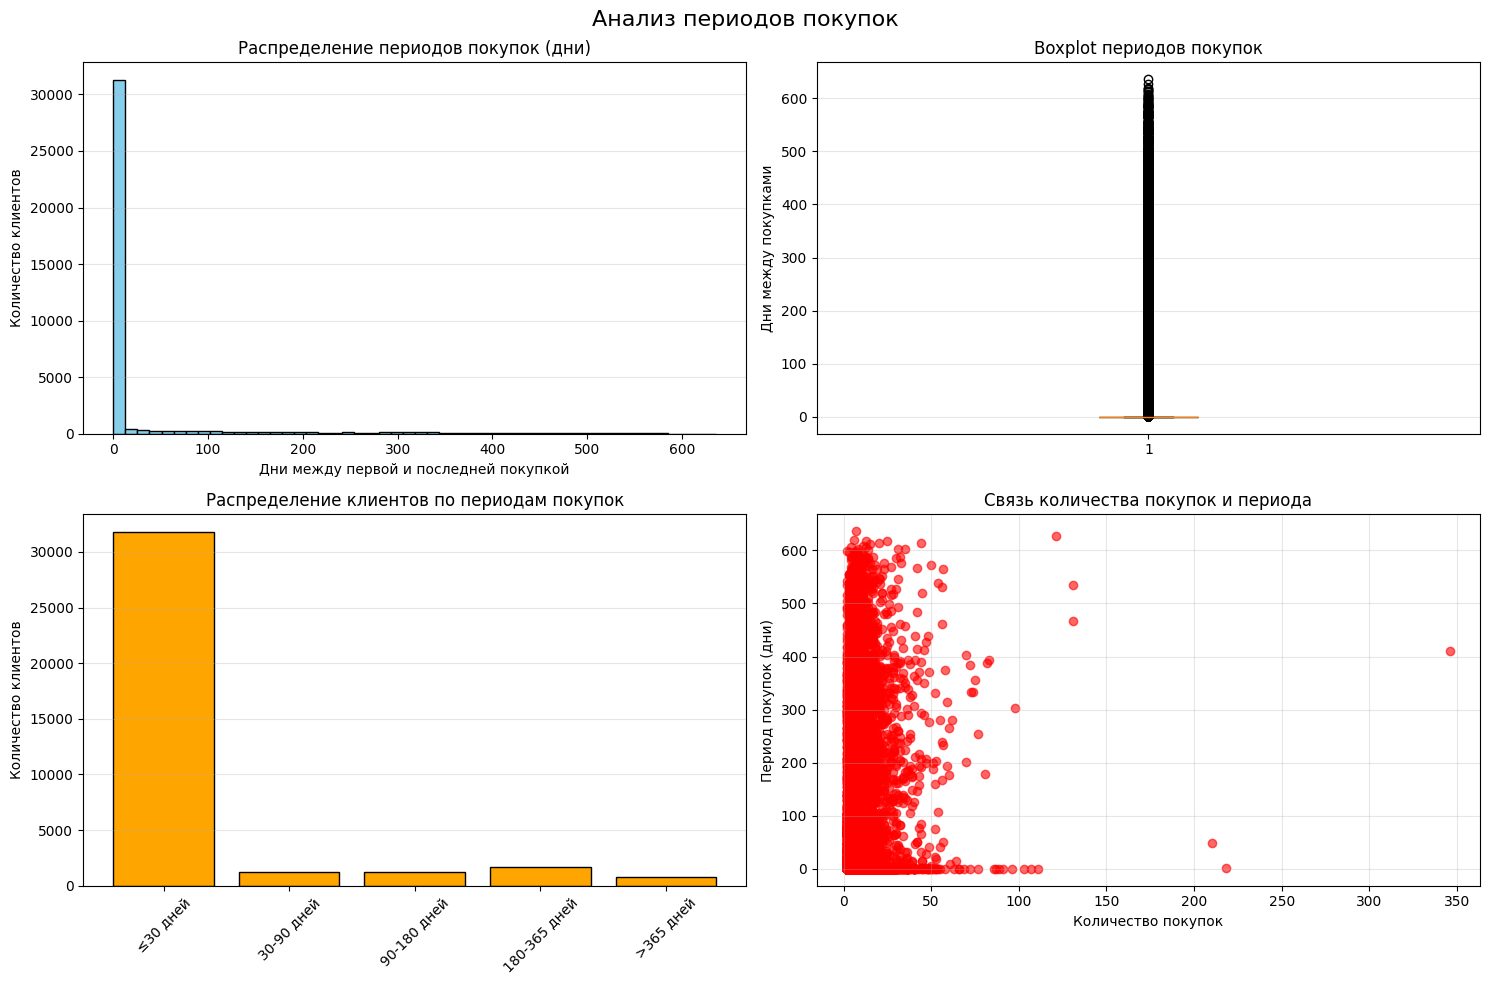


Топ-10 клиентов с самыми длинными периодами покупок:
                 client_id first_purchase last_purchase  purchase_period_days  \
4918   1515915625478751298     2022-05-17    2024-02-12                   636   
17169  1515915625491750681     2022-05-27    2024-02-13                   627   
7811   1515915625488290703     2022-05-17    2024-01-26                   619   
4381   1515915625475169728     2022-06-06    2024-02-13                   617   
9250   1515915625488916405     2022-06-02    2024-02-09                   617   
3285   1515915625471475990     2022-06-08    2024-02-12                   614   
1242   1515915625468159950     2022-05-30    2024-02-02                   613   
2304   1515915625468245266     2022-05-29    2024-01-30                   611   
2705   1515915625470689537     2022-06-04    2024-02-03                   609   
35088  1515915625592508593     2022-06-02    2024-01-30                   607   

       purchase_count  
4918                7  
17169 

In [122]:
# Рассчитываем периоды покупок
purchase_periods = calculate_purchase_period(df_purchases)

# Анализируем результаты
multiple_purchases = analyze_purchase_periods(purchase_periods)

# Создаем визуализацию
visualize_purchase_periods(purchase_periods)

# Показываем топ-10 клиентов с самыми длинными периодами
print("\nТоп-10 клиентов с самыми длинными периодами покупок:")
top_periods = purchase_periods.nlargest(10, 'purchase_period_days')
print(top_periods[['client_id', 'first_purchase', 'last_purchase', 'purchase_period_days', 'purchase_count']])

Создаем функцию накопительную таблицу покупок по периодам

In [123]:
def create_cumulative_purchase_features(df_purchases, periods=[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]):
    
    # Определяем дату отсечения (последняя дата в датасете)
    cutoff_date = df_purchases['date'].max()
    
    # Создаем базовую таблицу с уникальными client_id
    result_df = pd.DataFrame({'client_id': df_purchases['client_id'].unique()})
    
    print(f"Обработка {len(periods)} периодов для {len(result_df)} клиентов")
    print(f"Дата отсечения: {cutoff_date}")
    
    for period in periods:
        print(f"Обработка периода {period} дней...")
        
        # Вычисляем начальную дату для текущего периода
        start_date = cutoff_date - pd.Timedelta(days=period)
        
        # Фильтруем покупки за текущий период
        period_purchases = df_purchases[
            (df_purchases['date'] >= start_date) & 
            (df_purchases['date'] <= cutoff_date)
        ].copy()
        
        # Группируем по client_id и вычисляем агрегаты
        period_stats = period_purchases.groupby('client_id').agg({
            'price': ['sum', 'mean', 'count'],  # сумма, средняя цена, количество покупок
            'quantity': ['sum', 'mean']  # сумма и среднее количество штук
        }).reset_index()
        
        # Выравниваем названия столбцов
        period_stats.columns = ['client_id', 
                               f'price_sum_{period}d', f'price_mean_{period}d', f'purchase_count_{period}d',
                               f'quantity_sum_{period}d', f'quantity_mean_{period}d']
        
        # Объединяем с результатом
        result_df = result_df.merge(period_stats, on='client_id', how='left')
        
        # Заполняем пропущенные значения нулями
        for col in [f'price_sum_{period}d', f'price_mean_{period}d', f'purchase_count_{period}d',
                   f'quantity_sum_{period}d', f'quantity_mean_{period}d']:
            result_df[col] = result_df[col].fillna(0)
    
    print(f"Создано {len(result_df.columns)-1} признаков")
    return result_df

In [124]:
# Создаем накопительную таблицу с периодами по 30 дней до 360 дней
periods = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
cumulative_purchases = create_cumulative_purchase_features(df_purchases, periods)

Обработка 12 периодов для 49849 клиентов
Дата отсечения: 2024-02-16 00:00:00
Обработка периода 30 дней...
Обработка периода 60 дней...
Обработка периода 90 дней...
Обработка периода 120 дней...
Обработка периода 150 дней...
Обработка периода 180 дней...
Обработка периода 210 дней...
Обработка периода 240 дней...
Обработка периода 270 дней...
Обработка периода 300 дней...
Обработка периода 330 дней...
Обработка периода 360 дней...
Создано 60 признаков


In [125]:
# Выводим первые пячть строк
cumulative_purchases.head()

,client_id,price_sum_30d,price_mean_30d,purchase_count_30d,quantity_sum_30d,quantity_mean_30d,price_sum_60d,price_mean_60d,purchase_count_60d,quantity_sum_60d,...,price_sum_330d,price_mean_330d,purchase_count_330d,quantity_sum_330d,quantity_mean_330d,price_sum_360d,price_mean_360d,purchase_count_360d,quantity_sum_360d,quantity_mean_360d
0,1515915625468169594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18372.0,3062.0,6.0,6.0,1.0,18372.0,3062.0,6.0,6.0,1.0
1,1515915625471138230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1515915625471640575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1515915625490211585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1515915625490739153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# Выводим полную информацию о структуре
cumulative_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            49849 non-null  int64  
 1   price_sum_30d        49849 non-null  float64
 2   price_mean_30d       49849 non-null  float64
 3   purchase_count_30d   49849 non-null  float64
 4   quantity_sum_30d     49849 non-null  float64
 5   quantity_mean_30d    49849 non-null  float64
 6   price_sum_60d        49849 non-null  float64
 7   price_mean_60d       49849 non-null  float64
 8   purchase_count_60d   49849 non-null  float64
 9   quantity_sum_60d     49849 non-null  float64
 10  quantity_mean_60d    49849 non-null  float64
 11  price_sum_90d        49849 non-null  float64
 12  price_mean_90d       49849 non-null  float64
 13  purchase_count_90d   49849 non-null  float64
 14  quantity_sum_90d     49849 non-null  float64
 15  quantity_mean_90d    49849 non-null 

Функция для создания нового датасета с группировкой по client_id

In [127]:
def calculate_purchase_sum_per_period(df_purchases):

    # Группируем по client_id и вычисляем агрегаты
    result = df_purchases.groupby('client_id').agg({
        'price': ['sum', 'count'],  # сумма цен и количество покупок
        'quantity': 'sum'  # сумма количества товаров
    }).reset_index()
    
    # Выравниваем названия столбцов
    result.columns = [
        'client_id', 
        'total_purchase_sum', 
        'purchase_count',
        'total_quantity'
    ]
    
    return result

Применяем функцию

In [128]:
# Вызов функции для создания нового датасета с группировкой по client_id
df_purchases_summary =  calculate_purchase_sum_per_period(df_purchases)

# Посмотрим на результат
print("Размер нового датасета:", df_purchases_summary.shape)
print("\nПервые 5 строк:")
print(df_purchases_summary.head())

# Посмотрим на общую информацию о датасете
print("\nИнформация о датасете:")

df_purchases_summary.info()

Размер нового датасета: (49849, 4)

Первые 5 строк:
             client_id  total_purchase_sum  purchase_count  total_quantity
0  1515915625468060902              6993.0               7               7
1  1515915625468061003             16235.0               7               7
2  1515915625468061099               299.0               1               1
3  1515915625468061100              2098.0               2               2
4  1515915625468061170             33601.0              19              19

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           49849 non-null  int64  
 1   total_purchase_sum  49849 non-null  float64
 2   purchase_count      49849 non-null  int64  
 3   total_quantity      49849 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.5 MB


Создаем функцию для создания датасета с флагами покупок для разных периодов

In [129]:
def create_purchase_flags_dataset(df_purchases, periods=[90, 180, 270]):
    # Определяем дату отсечения (последняя дата в датасете)
    cutoff_date = df_purchases['date'].max()
    
    # Создаем базовую таблицу с уникальными client_id
    result_df = pd.DataFrame({'client_id': df_purchases['client_id'].unique()})
    
    print(f"Обработка {len(periods)} периодов для {len(result_df)} клиентов")
    print(f"Дата отсечения: {cutoff_date}")
    
    for period in periods:
        print(f"Обработка периода {period} дней...")
        
        # Вычисляем начальную дату для текущего периода
        start_date = cutoff_date - pd.Timedelta(days=period)
        
        # Фильтруем покупки за текущий период
        period_purchases = df_purchases[
            (df_purchases['date'] >= start_date) & 
            (df_purchases['date'] <= cutoff_date)
        ].copy()
        
        # Получаем уникальных клиентов, которые совершали покупки в этот период
        clients_with_purchases = set(period_purchases['client_id'].unique())
        
        # Создаем флаг: 1 если клиент совершал покупки, 0 если нет
        result_df[f'purchase_flag_{period}d'] = result_df['client_id'].apply(
            lambda x: 1 if x in clients_with_purchases else 0
        )
    
    print(f"Создано {len(periods)} флагов покупок")
    return result_df


Применяем функцию и выводим полученный датасет первые пять строк

In [130]:
df_purchase_flags = create_purchase_flags_dataset(df_purchases, [90, 180, 270])
df_purchase_flags.head()

Обработка 3 периодов для 49849 клиентов
Дата отсечения: 2024-02-16 00:00:00
Обработка периода 90 дней...
Обработка периода 180 дней...
Обработка периода 270 дней...
Создано 3 флагов покупок


,client_id,purchase_flag_90d,purchase_flag_180d,purchase_flag_270d
0,1515915625468169594,1,1,1
1,1515915625471138230,0,0,0
2,1515915625471640575,0,0,0
3,1515915625490211585,0,0,0
4,1515915625490739153,0,0,0


 Функция для создания датасета с расчетом периодов между покупками и времени до последней покупки

In [131]:
def calculate_purchase_intervals(df_purchases):
   
    # Определяем дату отсечения (последняя дата в датасете)
    cutoff_date = df_purchases['date'].max()
    
    # Группируем по client_id и сортируем по дате
    # Группируем данные по одному или нескольким столбцам
    grouped = df_purchases.groupby('client_id')['date'].apply(lambda x: x.sort_values()).reset_index()
    
    result_list = []
    for client_id, group in grouped.groupby('client_id'):
        dates = group['date'].values
        
        # Дни с последней покупки
        days_since_last = (cutoff_date - dates[-1]).days
        
        # Периоды между покупками (только если больше 1 покупки)
        if len(dates) > 1:
            intervals = []
            for i in range(1, len(dates)):
                interval = (dates[i] - dates[i-1]).astype('timedelta64[D]').astype(int)
                intervals.append(interval)
            
            avg_interval = np.mean(intervals)
            min_interval = np.min(intervals)
            max_interval = np.max(intervals)
        else:
            # Для клиентов с одной покупкой
            avg_interval = 0
            min_interval = 0
            max_interval = 0
        
        result_list.append({
            'client_id': client_id,
            'days_since_last_purchase': days_since_last,
            'avg_days_between_purchases': round(avg_interval, 2),
            'min_days_between_purchases': min_interval,
            'max_days_between_purchases': max_interval
        })
    
    result_df = pd.DataFrame(result_list)
    
    print(f"Обработано {len(result_df)} клиентов")
    print(f"Дата отсечения: {cutoff_date}")
    
    return result_df

Применяем функцию и отображаем первые пять строк, для проверки

In [132]:
df_purchase_intervals = calculate_purchase_intervals(df_purchases)
df_purchase_intervals.head()

Обработано 49849 клиентов
Дата отсечения: 2024-02-16 00:00:00


,client_id,days_since_last_purchase,avg_days_between_purchases,min_days_between_purchases,max_days_between_purchases
0,1515915625468060902,630,0.00,0,0
1,1515915625468061003,408,0.00,0,0
2,1515915625468061099,640,0.00,0,0
3,1515915625468061100,6,0.00,0,0
4,1515915625468061170,244,4.61,0,80


Функция для Ссоздания датасета с любимыми категориями товаров для каждого клиента

In [133]:
def find_favorite_category(df_purchases):

    result_list = []

    for client_id, group in df_purchases.groupby('client_id'):
        # Обрабатываем category_ids для каждого клиента
        categories = []
        
        for category_str in group['category_ids']:
            # Проверяем на пустые значения
            if pd.isna(category_str) or category_str == '' or category_str == '[]':
                categories.append('empty')
            else:
                # Парсим строку как список и берем последний элемент
                try:
                    # Убираем квадратные скобки и разбиваем по запятым
                    category_list = category_str.strip('[]').split(',')
                    # Берем последний элемент и убираем пробелы
                    last_category = category_list[-1].strip() if category_list else 'empty'
                    categories.append(last_category)
                except:
                    categories.append('empty')
        
        # Находим самую частую категорию
        # Импорт библиотеки для использования её функций
        from collections import Counter
        category_counts = Counter(categories)
        favorite_category = category_counts.most_common(1)[0][0]
        category_count = category_counts.most_common(1)[0][1]
        
        result_list.append({
            'client_id': client_id,
            'favorite_category': favorite_category,
            'category_count': category_count
        })
    
    result_df = pd.DataFrame(result_list)
    
    print(f"Обработано {len(result_df)} клиентов")
    print(f"Уникальных категорий: {result_df['favorite_category'].nunique()}")
    
    return result_df

Применяем функцию и отображаем первые пять строк, для проверки

In [134]:
df_favorite_categories = find_favorite_category(df_purchases)
print(df_favorite_categories.head())

Обработано 49849 клиентов
Уникальных категорий: 749
             client_id favorite_category  category_count
0  1515915625468060902             '458'               2
1  1515915625468061003             '615'               7
2  1515915625468061099             '424'               1
3  1515915625468061100            '5717'               2
4  1515915625468061170             '420'              12


Функция создает датасет с подсчетом количества каждого события для каждого клиента

In [135]:
def count_events_per_client(df_msg):
    
    # Группируем по client_id и event, считаем количество
    event_counts = df_msg.groupby(['client_id', 'event']).size().reset_index(name='count')
    
    # Создаем сводную таблицу
    pivot_table = event_counts.pivot(index='client_id', columns='event', values='count').fillna(0)
    
    # Переименовываем колонки для лучшей читаемости
    pivot_table.columns = [f'{event}_count' for event in pivot_table.columns]
    
    # Сбрасываем индекс, чтобы client_id стал обычной колонкой
    result_df = pivot_table.reset_index()
    
    # Убеждаемся, что все типы событий присутствуют
    all_events = ['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam', 
                  'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close']
    
    for event in all_events:
        col_name = f'{event}_count'
        if col_name not in result_df.columns:
            result_df[col_name] = 0
    
    # Сортируем колонки по алфавиту
    event_cols = sorted([col for col in result_df.columns if col.endswith('_count')])
    result_df = result_df[['client_id'] + event_cols]
    
    print(f"Обработано {len(result_df)} клиентов")
    print(f"Создано {len(event_cols)} колонок с событиями")
    
    return result_df

Применяем функцию и отображаем первые пять строк, для проверки

In [136]:
df_event_counts = count_events_per_client(df_msg)
df_event_counts.head()

Обработано 53329 клиентов
Создано 11 колонок с событиями


,client_id,click_count,close_count,complain_count,hard_bounce_count,hbq_spam_count,open_count,purchase_count,send_count,soft_bounce_count,subscribe_count,unsubscribe_count
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0


In [137]:
def combine_dataframes_by_client_id(*dataframes, base_dataframe=None):
    """
    Объединяет произвольное количество датафреймов по client_id
    
    Параметры:
    *dataframes: Произвольное количество датафреймов для объединения
    base_dataframe: Базовый датафрейм (если не указан, используется первый)
    
    Возвращает:
    DataFrame: Объединенный датафрейм
    """
    
    if not dataframes:
        raise ValueError("Необходимо передать хотя бы один датафрейм")
    
    print(f"Начинаем объединение {len(dataframes)} датафреймов...")
    
    # Определяем базовый датафрейм
    if base_dataframe is not None:
        combined_df = base_dataframe.copy()
        print(f"Базовый датафрейм: {combined_df.shape}")
    else:
        combined_df = dataframes[0].copy()
        print(f"Базовый датафрейм (первый): {combined_df.shape}")
    
    # Объединяем остальные датафреймы
    for i, df in enumerate(dataframes[1:] if base_dataframe is None else dataframes):
        print(f"Объединяем датафрейм {i+1}: {df.shape}")
        combined_df = combined_df.merge(df, on='client_id', how='left')
        print(f"Результат: {combined_df.shape}")
    
    # Заполняем пропущенные значения нулями для числовых колонок
    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
    combined_df[numeric_cols] = combined_df[numeric_cols].fillna(0)
    
    print(f"\nИтоговый размер датафрейма: {combined_df.shape}")
    print(f"Количество колонок: {len(combined_df.columns)}")
    
    return combined_df


In [138]:
# Вызов функции для объединения всех датафреймов
df_combined = combine_dataframes_by_client_id(
    df_purchases_summary, 
    df_purchase_flags, 
    df_purchase_intervals,
    df_favorite_categories, 
    df_event_counts,
    cumulative_purchases,
    df_target
)

# Показываем первые N строк датасета - для визуальной проверки структуры
# Что видим: типы данных, наличие пропусков, примеры значений
# Зачем: быстро убедиться, что данные загружены правильно
# Показываем первые N строк - визуальная проверка структуры
# Что видим: колонки, типы данных, примеры значений, пропуски
# Зачем: убедиться, что данные загружены и выглядят правильно
print(df_combined.head())
# Получаем размер датасета: (количество строк, количество столбцов)
# Что видим: конкретные числа размеров данных
# Зачем: убедиться, что при обработке не потеряли данные
print(f"\nРазмер итогового датафрейма: {df_combined.shape}")

Начинаем объединение 7 датафреймов...
Базовый датафрейм (первый): (49849, 4)
Объединяем датафрейм 1: (49849, 4)
Результат: (49849, 7)
Объединяем датафрейм 2: (49849, 5)
Результат: (49849, 11)
Объединяем датафрейм 3: (49849, 3)
Результат: (49849, 13)
Объединяем датафрейм 4: (53329, 12)
Результат: (49849, 24)
Объединяем датафрейм 5: (49849, 61)
Результат: (49849, 84)
Объединяем датафрейм 6: (49849, 2)
Результат: (49849, 85)

Итоговый размер датафрейма: (49849, 85)
Количество колонок: 85
             client_id  total_purchase_sum  purchase_count_x  total_quantity  \
0  1515915625468060902              6993.0                 7               7   
1  1515915625468061003             16235.0                 7               7   
2  1515915625468061099               299.0                 1               1   
3  1515915625468061100              2098.0                 2               2   
4  1515915625468061170             33601.0                19              19   

   purchase_flag_90d  purchas

In [ ]:
def analyze_missing_values(df, df_name="DataFrame"):
    """
    Анализирует пропущенные значения в датафрейме
    
    Параметры:
    df (DataFrame): Датафрейм для анализа
    df_name (str): Название датафрейма для вывода
    
    Возвращает:
    DataFrame: Таблица с информацией о пропущенных значениях
    """
    
    print(f"АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ: {df_name}")
    print("="*60)
    
    # Общая информация
    total_rows = len(df)
    total_cols = len(df.columns)
    
    print(f"Размер датафрейма: {total_rows:,} строк × {total_cols} столбцов")
    print(f"Общее количество ячеек: {total_rows * total_cols:,}")
    
    # Анализ пропусков по столбцам
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / total_rows * 100).round(2)
    
    # Создаем таблицу с результатами
    missing_info = pd.DataFrame({
        'column_name': missing_data.index,
        'missing_count': missing_data.values,
        'missing_percent': missing_percent.values
    })
    
    # Сортируем по количеству пропусков
    missing_info = missing_info.sort_values('missing_count', ascending=False)
    
    # Фильтруем только столбцы с пропусками
    columns_with_missing = missing_info[missing_info['missing_count'] > 0]
    
    if len(columns_with_missing) > 0:
        print(f"\nНайдено {len(columns_with_missing)} столбцов с пропусками:")
        print("-" * 60)
        print(columns_with_missing.to_string(index=False))
        
        # Статистика
        total_missing = missing_data.sum()
        print(f"\nОбщее количество пропусков: {total_missing:,}")
        print(f"Процент пропусков от всех ячеек: {(total_missing / (total_rows * total_cols) * 100):.2f}%")
        
        # Топ-5 столбцов с наибольшим количеством пропусков
        print(f"\nТоп-5 столбцов с наибольшим количеством пропусков:")
        # Показываем первые N строк - визуальная проверка структуры
        # Что видим: колонки, типы данных, примеры значений, пропуски
        # Зачем: убедиться, что данные загружены и выглядят правильно
        print(columns_with_missing.head().to_string(index=False))
        
    else:
        print("\nПропущенных значений не найдено!")
    
    # Анализ строк с пропусками
    rows_with_missing = df.isnull().any(axis=1).sum()
    if rows_with_missing > 0:
        print(f"\nСтрок с пропусками: {rows_with_missing:,} ({(rows_with_missing/total_rows*100):.2f}%)")
        
        # Показываем примеры строк с пропусками
        print(f"\nПримеры строк с пропусками:")
        missing_rows = df[df.isnull().any(axis=1)]
        # Показываем первые N строк датасета - для визуальной проверки структуры
        # Что видим: типы данных, наличие пропусков, примеры значений
        # Зачем: быстро убедиться, что данные загружены правильно
        # Показываем первые N строк - визуальная проверка структуры
        # Что видим: колонки, типы данных, примеры значений, пропуски
        # Зачем: убедиться, что данные загружены и выглядят правильно
        print(missing_rows.head().to_string())
    
    print("="*60)
    
    return missing_info

# Пример использования:
# missing_analysis = analyze_missing_values(df_combined, "df_combined")

In [140]:
# Вызов функции для анализа пропущенных значений
missing_analysis = analyze_missing_values(df_combined, "df_combined")

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ: df_combined
Размер датафрейма: 49,849 строк × 85 столбцов
Общее количество ячеек: 4,237,165

✅ Пропущенных значений не найдено!


In [141]:
def analyze_feature_correlations(df, target_column: str = None, exclude_columns: list = None):
    """
    Анализирует корреляции признаков с целевой переменной, строит тепловую карту и рассчитывает VIF.
    Результаты выводятся прямо в Jupyter.
    
    Параметры:
    df (DataFrame): Датафрейм для анализа
    target_column (str): Название целевой колонки
    exclude_columns (list): Список колонок для исключения из анализа
    """
    # Импорт библиотеки для использования её функций
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    if exclude_columns is None:
        exclude_columns = []

    df_analysis = df.copy()

    # Преобразуем категориальные переменные в числовые
    categorical_columns = df_analysis.select_dtypes(include=["object", "category"]).columns
    for col in categorical_columns:
        df_analysis[col] = df_analysis[col].astype("category").cat.codes

    # Получаем числовые колонки
    numeric_columns = df_analysis.select_dtypes(exclude=["object", "category"]).columns.tolist()
    if target_column not in numeric_columns:
        raise ValueError(f"Целевая колонка '{target_column}' должна быть числовой")

    # Рассчитываем корреляции с целевой переменной
    correlations_with_target = (
        df_analysis[numeric_columns]
        .corr()[target_column]
        .drop(target_column)
        .sort_values(key=np.abs, ascending=False)
    )
    
    print("=== КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")
    print(correlations_with_target)

    # Строим тепловую карту корреляций
    heatmap_columns = [
        col for col in numeric_columns if col not in exclude_columns or col == target_column
    ]
    correlation_matrix = df_analysis[heatmap_columns].corr()

    plt.figure(figsize=(15, 12))
    plt.imshow(correlation_matrix, interpolation="nearest", cmap="RdBu_r", aspect="auto")
    plt.xticks(
        range(len(correlation_matrix.columns)), 
        correlation_matrix.columns, 
        rotation=90, 
        fontsize=6
    )
    plt.yticks(
        range(len(correlation_matrix.columns)), 
        correlation_matrix.columns, 
        fontsize=6
    )
    plt.colorbar()
    plt.title("Тепловая карта корреляций (включая целевую переменную)", fontsize=14)

    # Добавляем значения корреляций на карту
    # Получаем размер: (количество строк, количество столбцов)
    # Что видим: конкретные числа (например: 10000, 25)
    # Зачем: проверить объем данных и не потеряли ли мы строки
    for i in range(correlation_matrix.shape[0]):
        # Получаем размер: (количество строк, количество столбцов)
        # Что видим: конкретные числа (например: 10000, 25)
        # Зачем: проверить объем данных и не потеряли ли мы строки
        for j in range(correlation_matrix.shape[1]):
            value = correlation_matrix.iloc[i, j]
            plt.text(
                j,
                i,
                f"{value:.2f}",
                ha="center",
                va="center",
                fontsize=4,
                color="black",
            )

    plt.tight_layout()
    plt.show()

    # Рассчитываем VIF (Variance Inflation Factor)
    vif_columns = [
        col for col in numeric_columns if col != target_column and col not in exclude_columns
    ]
    X_vif = df_analysis[vif_columns].copy()
    
    # Масштабируем данные
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_columns)

    # Рассчитываем VIF для каждой переменной
    vif_results = pd.DataFrame()
    vif_results["признак"] = vif_columns
    vif_results["VIF"] = [
        # Получаем размер: (количество строк, количество столбцов)
        # Что видим: конкретные числа (например: 10000, 25)
        # Зачем: проверить объем данных и не потеряли ли мы строки
        variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
    ]
    vif_results = vif_results.sort_values("VIF", ascending=False)

    print("\n=== VIF (Variance Inflation Factor) ===")
    print(vif_results)
    
    return correlations_with_target, vif_results

=== КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
max_days_between_purchases    0.085385
purchase_flag_180d            0.081702
purchase_count_180d           0.081610
quantity_sum_180d             0.081450
quantity_mean_180d            0.080283
                                ...   
soft_bounce_count            -0.004582
hbq_spam_count               -0.004258
client_id                    -0.004213
complain_count               -0.000826
close_count                  -0.000628
Name: target, Length: 84, dtype: float64


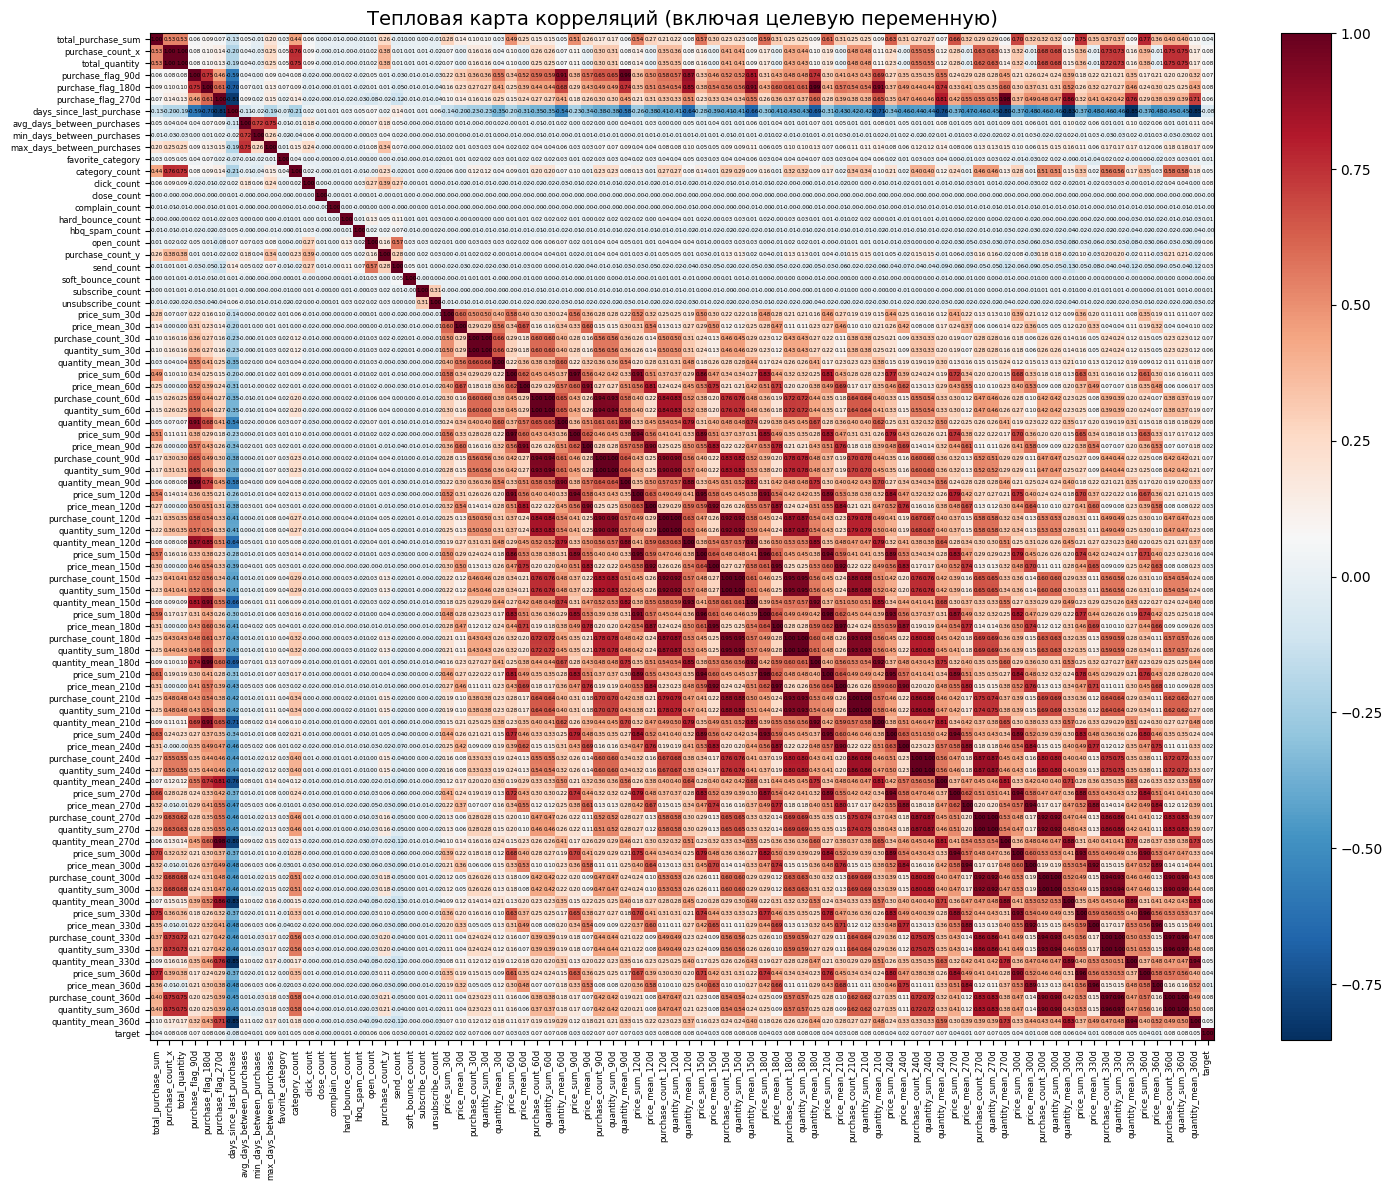


=== VIF (Variance Inflation Factor) ===
                признак           VIF
51    quantity_sum_180d  65594.975605
50  purchase_count_180d  64848.503676
46    quantity_sum_150d  52248.929417
45  purchase_count_150d  51499.898614
41    quantity_sum_120d  47925.311109
..                  ...           ...
21      subscribe_count      1.107527
16       hbq_spam_count      1.023685
20    soft_bounce_count      1.010125
14       complain_count      1.001179
13          close_count      1.000504

[83 rows x 2 columns]


In [142]:
# Анализ корреляций признаков с целевой переменной
correlations, vif_scores = analyze_feature_correlations(
    df_combined, 
    target_column='target', 
    exclude_columns=['client_id']
)

Функция удаления указанных столбцов из датафрейма

In [ ]:
def remove_columns(df, columns_to_remove, show_info=True):

    if show_info:
        print("="*60)
        print("УДАЛЕНИЕ СТОЛБЦОВ")
        print("="*60)
        print(f"Исходное количество столбцов: {len(df.columns)}")
    
    # Проверяем, какие столбцы существуют в датафрейме
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    missing_columns = [col for col in columns_to_remove if col not in df.columns]
    
    if show_info:
        if existing_columns:
            print(f"\nСтолбцы для удаления ({len(existing_columns)}):")
            for col in existing_columns:
                print(f"  • {col}")
        
        if missing_columns:
            print(f"\nСтолбцы не найдены ({len(missing_columns)}):")
            for col in missing_columns:
                print(f"  • {col}")
    
    # Удаляем существующие столбцы
    df_cleaned = df.drop(columns=existing_columns)
    
    if show_info:
        print(f"\nИтоговое количество столбцов: {len(df_cleaned.columns)}")
        print(f"Удалено столбцов: {len(existing_columns)}")
        print("="*60)
    
    return df_cleaned

Определяем список столбцов и запускаем их удаление через функцию.

In [144]:
columns_to_remove = ['quantity_sum_180d', 'quantity_sum_120d', 'quantity_sum_330d', \
    'quantity_sum_90d', 'quantity_sum_300d', 'quantity_sum_270d', 'purchase_count_150d',\
         'quantity_sum_60d', 'purchase_count_360d', 'quantity_sum_30d', 'purchase_count_210d', \
            'quantity_sum_240d', 'quantity_mean_180d', 'purchase_count_x', 'price_sum_210d', \
                'price_sum_330d', 'quantity_mean_90d', 'price_sum_90d', 'quantity_mean_270d', 'price_sum_150d',\
                     'price_mean_180d', 'price_sum_270d', 'purchase_count_300d', 'price_mean_300d', 'price_sum_240d', \
                     'price_sum_120d', 'quantity_mean_150d', 'quantity_sum_360d', 'price_mean_330d', 'purchase_count_180d',\
                         'purchase_flag_90d', 'price_mean_210d', 'purchase_flag_270d', 'price_mean_120d', 'purchase_count_120d',\
                             'quantity_mean_330d', 'quantity_mean_210d', 'price_sum_360d', 'purchase_count_60d', 'price_sum_180d',\
                                 'price_mean_240d', 'price_mean_60d', 'purchase_count_240d', 'days_since_last_purchase']


df_cleaned1 = remove_columns(df_combined, columns_to_remove)

УДАЛЕНИЕ СТОЛБЦОВ
Исходное количество столбцов: 85

Столбцы для удаления (44):
  • quantity_sum_180d
  • quantity_sum_120d
  • quantity_sum_330d
  • quantity_sum_90d
  • quantity_sum_300d
  • quantity_sum_270d
  • purchase_count_150d
  • quantity_sum_60d
  • purchase_count_360d
  • quantity_sum_30d
  • purchase_count_210d
  • quantity_sum_240d
  • quantity_mean_180d
  • purchase_count_x
  • price_sum_210d
  • price_sum_330d
  • quantity_mean_90d
  • price_sum_90d
  • quantity_mean_270d
  • price_sum_150d
  • price_mean_180d
  • price_sum_270d
  • purchase_count_300d
  • price_mean_300d
  • price_sum_240d
  • price_sum_120d
  • quantity_mean_150d
  • quantity_sum_360d
  • price_mean_330d
  • purchase_count_180d
  • purchase_flag_90d
  • price_mean_210d
  • purchase_flag_270d
  • price_mean_120d
  • purchase_count_120d
  • quantity_mean_330d
  • quantity_mean_210d
  • price_sum_360d
  • purchase_count_60d
  • price_sum_180d
  • price_mean_240d
  • price_mean_60d
  • purchase_count_240d
 

Функция удаления признаков с высокой зависимостью(VIF) друг с другом и создание очищенного датафрейма

In [145]:
def remove_high_vif_features(df, target_column: str = None, exclude_columns: list = None, 
                           vif_threshold: float = 10.0):
   
    if exclude_columns is None:
        exclude_columns = []

    df_analysis = df.copy()
    
    print(f"Начинаем анализ VIF с порогом {vif_threshold}")
    print("="*60)

    # Преобразуем категориальные переменные в числовые
    categorical_columns = df_analysis.select_dtypes(include=["object", "category"]).columns
    for col in categorical_columns:
        df_analysis[col] = df_analysis[col].astype("category").cat.codes

    # Получаем числовые колонки
    numeric_columns = df_analysis.select_dtypes(exclude=["object", "category"]).columns.tolist()
    if target_column not in numeric_columns:
        raise ValueError(f"Целевая колонка '{target_column}' должна быть числовой")

    # Итеративно удаляем столбцы с высоким VIF
    removed_columns = []
    iteration = 0
    
    while True:
        iteration += 1
        print(f"\n--- Итерация {iteration} ---")
        
        # Определяем столбцы для анализа VIF
        vif_columns = [
            col for col in numeric_columns 
            if col != target_column and col not in exclude_columns and col not in removed_columns
        ]
        
        if len(vif_columns) == 0:
            print("Нет столбцов для анализа VIF")
            break
            
        print(f"Анализируем {len(vif_columns)} столбцов...")
        
        # Подготавливаем данные для VIF
        X_vif = df_analysis[vif_columns].copy()
        
        # Проверяем на бесконечные значения и NaN
        if X_vif.isnull().any().any() or np.isinf(X_vif).any().any():
            print("Обнаружены NaN или бесконечные значения, пропускаем итерацию")
            break
            
        # Масштабируем данные
        scaler = RobustScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_columns)
        
        # Рассчитываем VIF
        vif_results = pd.DataFrame()
        vif_results["признак"] = vif_columns
        vif_results["VIF"] = [
            variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
        ]
        vif_results = vif_results.sort_values("VIF", ascending=False)
        
        print("VIF результаты:")
        print(vif_results)
        
        # Находим столбцы с VIF выше порога
        high_vif_columns = vif_results[vif_results["VIF"] > vif_threshold]["признак"].tolist()
        
        if not high_vif_columns:
            print(f"Все VIF значения <= {vif_threshold}. Остановка.")
            break
            
        # Удаляем столбец с максимальным VIF
        column_to_remove = high_vif_columns[0]
        removed_columns.append(column_to_remove)
        print(f"Удаляем столбец: {column_to_remove} (VIF = {vif_results[vif_results['признак'] == column_to_remove]['VIF'].iloc[0]:.2f})")
    
    # Создаем очищенный датафрейм
    columns_to_keep = [col for col in df.columns if col not in removed_columns]
    df_cleaned = df[columns_to_keep].copy()
    
    print(f"\n=== РЕЗУЛЬТАТ ===")
    # Получаем размер датасета: (количество строк, количество столбцов)
    print(f"Исходный размер: {df.shape}")
    print(f"Очищенный размер: {df_cleaned.shape}")
    print(f"Удалено столбцов: {len(removed_columns)}")
    print(f"Удаленные столбцы: {removed_columns}")
    
    return df_cleaned, removed_columns, vif_results



ПРименяем функцию.

In [146]:
# Удаление столбцов с высоким VIF и создание очищенного датафрейма
df_cleaned, removed_cols, final_vif = remove_high_vif_features(
    df_cleaned1, 
    target_column='target', 
    exclude_columns=['client_id'],
    # VIF_THRESHOLD: пороговое значение для удаления мультиколлинеарных признаков
    # Значение 9.0: если VIF > 9, признак сильно зависит от других
    # Результат: улучшение обобщаемости модели
    vif_threshold=VIF_THRESHOLD
)

Начинаем анализ VIF с порогом 9.0

--- Итерация 1 ---
Анализируем 39 столбцов...
VIF результаты:
                       признак       VIF
29           quantity_sum_150d  8.977280
36         purchase_count_330d  7.954590
3   avg_days_between_purchases  7.666121
32             price_mean_270d  7.381005
33         purchase_count_270d  7.179603
30           quantity_sum_210d  7.040417
27          quantity_mean_120d  7.012922
34              price_sum_300d  6.810224
2           purchase_flag_180d  6.658349
28             price_mean_150d  6.253880
1               total_quantity  5.808970
25              price_mean_90d  5.573606
26          purchase_count_90d  5.413370
37             price_mean_360d  5.233331
31          quantity_mean_240d  4.993965
24           quantity_mean_60d  4.954096
35          quantity_mean_300d  4.720740
5   max_days_between_purchases  4.681602
23               price_sum_60d  4.224517
22           quantity_mean_30d  3.929715
0           total_purchase_sum  3.806959
2

Выводим информацию полученного датасета

In [147]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   49849 non-null  int64  
 1   total_purchase_sum          49849 non-null  float64
 2   total_quantity              49849 non-null  int64  
 3   purchase_flag_180d          49849 non-null  int64  
 4   avg_days_between_purchases  49849 non-null  float64
 5   min_days_between_purchases  49849 non-null  int64  
 6   max_days_between_purchases  49849 non-null  int64  
 7   favorite_category           49849 non-null  object 
 8   category_count              49849 non-null  int64  
 9   click_count                 49849 non-null  float64
 10  close_count                 49849 non-null  float64
 11  complain_count              49849 non-null  float64
 12  hard_bounce_count           49849 non-null  float64
 13  hbq_spam_count              498

Анализ корреляций для очищенного датафрейма

=== КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
max_days_between_purchases    0.085385
purchase_flag_180d            0.081702
click_count                   0.079533
quantity_sum_150d             0.079037
quantity_mean_120d            0.078481
total_quantity                0.076673
quantity_sum_210d             0.076175
purchase_count_330d           0.075731
quantity_mean_60d             0.075068
purchase_count_90d            0.074933
quantity_mean_30d             0.072895
purchase_count_270d           0.070243
quantity_mean_240d            0.066296
purchase_count_30d            0.065234
purchase_count_y              0.063665
open_count                    0.058112
quantity_mean_300d            0.057069
quantity_mean_360d            0.052867
category_count                0.052405
avg_days_between_purchases    0.043254
price_sum_300d                0.039597
total_purchase_sum            0.037052
send_count                    0.032055
price_mean_150d               0.029320
price_sum_60d           

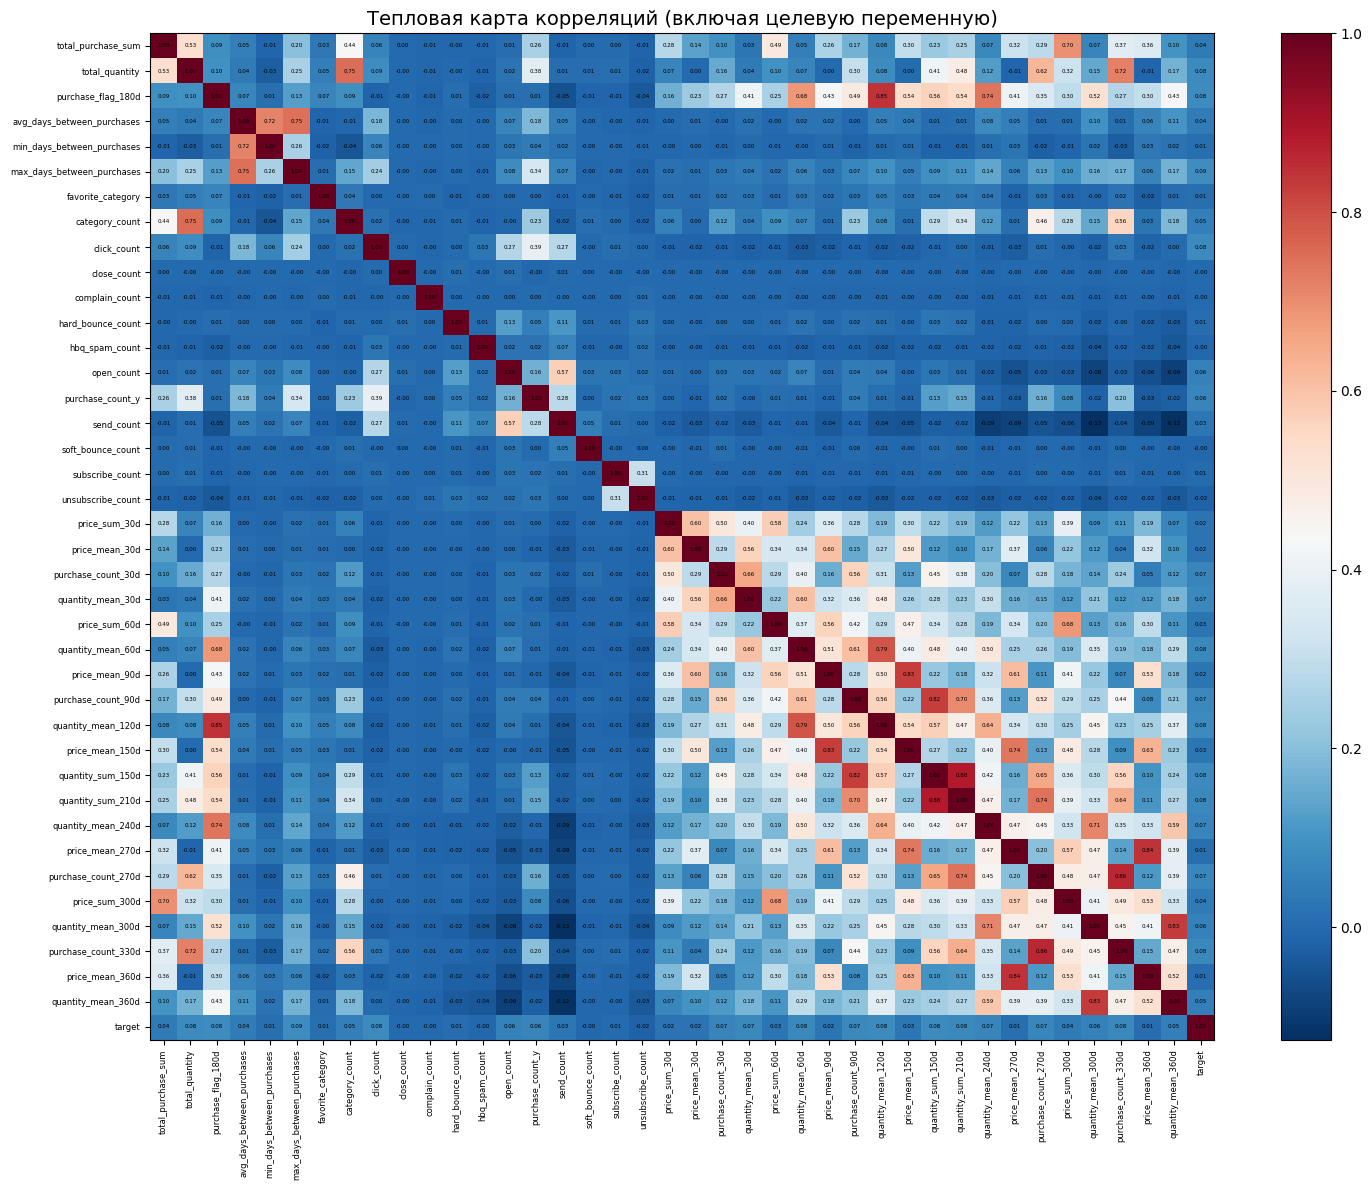


=== VIF (Variance Inflation Factor) ===
                       признак       VIF
29           quantity_sum_150d  8.977280
36         purchase_count_330d  7.954590
3   avg_days_between_purchases  7.666121
32             price_mean_270d  7.381005
33         purchase_count_270d  7.179603
30           quantity_sum_210d  7.040417
27          quantity_mean_120d  7.012922
34              price_sum_300d  6.810224
2           purchase_flag_180d  6.658349
28             price_mean_150d  6.253880
1               total_quantity  5.808970
25              price_mean_90d  5.573606
26          purchase_count_90d  5.413370
37             price_mean_360d  5.233331
31          quantity_mean_240d  4.993965
24           quantity_mean_60d  4.954096
35          quantity_mean_300d  4.720740
5   max_days_between_purchases  4.681602
23               price_sum_60d  4.224517
22           quantity_mean_30d  3.929715
0           total_purchase_sum  3.806959
20              price_mean_30d  3.471846
4   min_days_bet

In [148]:

correlations_cleaned, vif_scores_cleaned = analyze_feature_correlations(
    df_cleaned, 
    target_column='target', 
    exclude_columns=['client_id']
)

Функция обучает модели с использованием Optuna и SelectKBest для отбора признаков

In [ ]:
def train_with_optuna_and_selectkbest(df_cleaned, target_column='target', test_size=0.2, 
                               random_state=42, n_trials=100):
    """
     Параметры:
    df_cleaned (DataFrame): Очищенный датафрейм
    target_column (str): Название целевой колонки
    test_size (float): Размер тестовой выборки
    random_state (int): Seed для воспроизводимости
    n_trials (int): Количество попыток для Optuna
    
    Возвращает:
    dict: Словарь с результатами оптимизации
    tuple: (optuna_results, results_df, X_train, y_train, X_test, y_test)
    """

    warnings.filterwarnings('ignore')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    print("="*70)
    print("ОБУЧЕНИЕ")
    print("="*70)
    
    # Разделяем данные
    X = df_cleaned.drop(columns=[target_column])
    y = df_cleaned[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    
    # Колонки
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    # Препроцессоры
    preprocessor_ohe = ColumnTransformer([
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])
    
    preprocessor_ord = ColumnTransformer([
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ])
    
    X_train_ohe = preprocessor_ohe.fit_transform(X_train)
    X_train_ord = preprocessor_ord.fit_transform(X_train)
    n_features_ohe = X_train_ohe.shape[1]
    n_features_ord = X_train_ord.shape[1]
    
    print(f"Признаков OHE: {n_features_ohe}, Ordinal: {n_features_ord}")
    
    optuna_results = {}
    
    # ==========================================
    # 1. LOGISTIC REGRESSION
    # ==========================================
    print("\n" + "="*70)
    print("1. LOGISTIC REGRESSION")
    print("="*70)
    
    def objective_logreg(trial):
        k_best = trial.suggest_int("k", max(20, int(n_features_ohe * 0.4)), n_features_ohe)
        C = trial.suggest_float("C", 0.001, 100.0, log=True)
        solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear'])
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor_ohe),
            ('selectkbest', SelectKBest(f_classif, k=k_best)),
            ('classifier', LogisticRegression(C=C, solver=solver, max_iter=2000, random_state=random_state))
        ])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
        return scores.mean()
    
    study_logreg = optuna.create_study(direction='maximize')
    study_logreg.optimize(objective_logreg, n_trials=n_trials)
    
    best_params = study_logreg.best_params
    pipeline_logreg = Pipeline([
        ('preprocessor', preprocessor_ohe),
        ('selectkbest', SelectKBest(f_classif, k=best_params['k'])),
        ('classifier', LogisticRegression(C=best_params['C'], solver=best_params['solver'], 
                                         max_iter=2000, random_state=random_state))
    ])
    
    # Обучаем модель на обучающих данных
    # Процесс: модель ищет закономерности между X_train и y_train
    # Результат: обученная модель, готовая делать предсказания
    pipeline_logreg.fit(X_train, y_train)
    
    train_auc = roc_auc_score(y_train, pipeline_logreg.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, pipeline_logreg.predict_proba(X_test)[:, 1])
    
    print(f"Params: {best_params}")
    print(f"CV: {study_logreg.best_value:.4f} | Train: {train_auc:.4f} | Test: {test_auc:.4f} | Gap: {(train_auc-test_auc):.4f}")
    
    optuna_results['LogisticRegression'] = {
        'model': pipeline_logreg,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'cv_score': study_logreg.best_value,
        'best_params': best_params
    }
    
    # ==========================================
    # 2. LIGHTGBM
    # ==========================================
    print("\n" + "="*70)
    print("2. LIGHTGBM")
    print("="*70)
    
    def objective_lgbm(trial):
        k_best = trial.suggest_int("k", max(20, int(n_features_ord * 0.4)), n_features_ord)
        
        # Баланс между качеством и регуляризацией
        n_estimators = trial.suggest_int("n_estimators", 400, 1000)
        max_depth = trial.suggest_int("max_depth", 3, 6)
        learning_rate = trial.suggest_float("learning_rate", 0.003, 0.03, log=True)
        num_leaves = trial.suggest_int("num_leaves", 25, 50)
        min_child_samples = trial.suggest_int("min_child_samples", 50, 100)
        
        # Регуляризация (умеренная)
        reg_alpha = trial.suggest_float("reg_alpha", 0.5, 2.5)
        reg_lambda = trial.suggest_float("reg_lambda", 0.5, 2.5)
        subsample = trial.suggest_float("subsample", 0.7, 0.9)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 0.9)
        min_split_gain = trial.suggest_float("min_split_gain", 0, 0.03)
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor_ord),
            ('selectkbest', SelectKBest(f_classif, k=k_best)),
            ('classifier', lgb.LGBMClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                min_split_gain=min_split_gain,
                random_state=random_state,
                verbose=-1
            ))
        ])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
        return scores.mean()
    
    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective_lgbm, n_trials=n_trials)
    
    best_params = study_lgbm.best_params
    pipeline_lgbm = Pipeline([
        ('preprocessor', preprocessor_ord),
        ('selectkbest', SelectKBest(f_classif, k=best_params['k'])),
        ('classifier', lgb.LGBMClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            num_leaves=best_params['num_leaves'],
            min_child_samples=best_params['min_child_samples'],
            reg_alpha=best_params['reg_alpha'],
            reg_lambda=best_params['reg_lambda'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            min_split_gain=best_params.get('min_split_gain', 0),
            random_state=random_state,
            verbose=-1
        ))
    ])
    
    # Обучаем модель на обучающих данных
    # Процесс: модель ищет закономерности между X_train и y_train
    # Результат: обученная модель, готовая делать предсказания

    pipeline_lgbm.fit(X_train, y_train)
    
    train_auc = roc_auc_score(y_train, pipeline_lgbm.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, pipeline_lgbm.predict_proba(X_test)[:, 1])
    
    print(f"Params: {best_params}")
    print(f"CV: {study_lgbm.best_value:.4f} | Train: {train_auc:.4f} | Test: {test_auc:.4f} | Gap: {(train_auc-test_auc):.4f}")
    
    optuna_results['LightGBM'] = {
        'model': pipeline_lgbm,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'cv_score': study_lgbm.best_value,
        'best_params': best_params
    }
    
    # ==========================================
    # 3. RANDOM FOREST
    # ==========================================
    print("\n" + "="*70)
    print("3. RANDOM FOREST")
    print("="*70)
    
    def objective_rf(trial):
        k_best = trial.suggest_int("k", max(20, int(n_features_ord * 0.4)), n_features_ord)
        
        # Умеренная регуляризация для баланса
        n_estimators = trial.suggest_int("n_estimators", 150, 500)
        max_depth = trial.suggest_int("max_depth", 3, 8)
        min_samples_split = trial.suggest_int("min_samples_split", 40, 120)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 30, 80)
        max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
        max_samples = trial.suggest_float("max_samples", 0.5, 0.8)
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor_ord),
            ('selectkbest', SelectKBest(f_classif, k=k_best)),
            ('classifier', RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                max_samples=max_samples,
                random_state=random_state,
                n_jobs=-1
            ))
        ])
        
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
        return scores.mean()
    
    study_rf = optuna.create_study(direction='maximize')
    study_rf.optimize(objective_rf, n_trials=n_trials)
    
    best_params = study_rf.best_params
    pipeline_rf = Pipeline([
        ('preprocessor', preprocessor_ord),
        ('selectkbest', SelectKBest(f_classif, k=best_params['k'])),
        ('classifier', RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            max_samples=best_params['max_samples'],
            random_state=random_state,
            n_jobs=-1
        ))
    ])
    
    # Обучаем модель на обучающих данных
    # Процесс: модель ищет закономерности между X_train и y_train
    # Результат: обученная модель, готовая делать предсказания

    pipeline_rf.fit(X_train, y_train)
    
    train_auc = roc_auc_score(y_train, pipeline_rf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:, 1])
    
    print(f"Params: {best_params}")
    print(f"CV: {study_rf.best_value:.4f} | Train: {train_auc:.4f} | Test: {test_auc:.4f} | Gap: {(train_auc-test_auc):.4f}")
    
    optuna_results['RandomForest'] = {
        'model': pipeline_rf,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'cv_score': study_rf.best_value,
        'best_params': best_params
    }
    
    # ==========================================
    # РЕЗУЛЬТАТЫ
    # ==========================================
    print("\n" + "="*70)
    print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
    print("="*70)
    
    results_df = pd.DataFrame({
        'Model': list(optuna_results.keys()),
        'CV Score': [optuna_results[m]['cv_score'] for m in optuna_results.keys()],
        'Train ROC AUC': [optuna_results[m]['train_auc'] for m in optuna_results.keys()],
        'Test ROC AUC': [optuna_results[m]['test_auc'] for m in optuna_results.keys()],
        'Gap': [optuna_results[m]['train_auc'] - optuna_results[m]['test_auc'] for m in optuna_results.keys()],
        'K': [optuna_results[m]['best_params']['k'] for m in optuna_results.keys()]
    })
    
    results_df = results_df.sort_values('Test ROC AUC', ascending=False)
    print(results_df.to_string(index=False))
    
    # Проверяем цель
    best_test_auc = results_df.iloc[0]['Test ROC AUC']
    if best_test_auc >= 0.7:
        print(f"\nЦЕЛЬ ДОСТИГНУТА! Best Test ROC AUC = {best_test_auc:.4f}")
    else:
        print(f"\nЦель не достигнута. Best Test ROC AUC = {best_test_auc:.4f} (нужно >= 0.7)")
    
    return optuna_results, results_df, X_train, y_train, X_test, y_test




ВЫзов функции для моделей

In [150]:
# Вызов функции
optuna_results, optuna_results_df, X_train, y_train, X_test, y_test = train_with_optuna_and_selectkbest(
    df_cleaned, 
    target_column='target',

    test_size=TEST_SIZE,
    
    random_state=RANDOM_STATE,

    n_trials=N_TRIALS
)

ОБУЧЕНИЕ
Train: (39879, 40), Test: (9970, 40)
Признаков OHE: 774, Ordinal: 40

1. LOGISTIC REGRESSION
Params: {'k': 767, 'C': 0.3188080665428368, 'solver': 'lbfgs'}
CV: 0.7151 | Train: 0.7597 | Test: 0.7011 | Gap: 0.0585

2. LIGHTGBM
Params: {'k': 30, 'n_estimators': 570, 'max_depth': 3, 'learning_rate': 0.010669198738398666, 'num_leaves': 50, 'min_child_samples': 72, 'reg_alpha': 1.3507666123148656, 'reg_lambda': 1.9527003408362713, 'subsample': 0.8451163009941141, 'colsample_bytree': 0.6016560460381685, 'min_split_gain': 0.008953531480124264}
CV: 0.7419 | Train: 0.7840 | Test: 0.7617 | Gap: 0.0223

3. RANDOM FOREST
Params: {'k': 27, 'n_estimators': 193, 'max_depth': 7, 'min_samples_split': 87, 'min_samples_leaf': 49, 'max_features': 'sqrt', 'max_samples': 0.5946987977912596}
CV: 0.7363 | Train: 0.7867 | Test: 0.7425 | Gap: 0.0442

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
             Model  CV Score  Train ROC AUC  Test ROC AUC      Gap   K
          LightGBM  0.741895       0.784014      0.761695 0.0223

Функция для полного анализа лучшей модели: Feature Importance, SHAP, Permutation Importance

In [ ]:
def analyze_best_model(optuna_results, optuna_results_df, df_cleaned, 
                       X_train, y_train, top_n=20):
    def get_feature_names(preprocessor):
        """Получаем имена признаков из ColumnTransformer."""
        feature_names = []

        for name, transformer, cols in preprocessor.transformers_:
            if transformer == "drop":
                continue

            if isinstance(transformer, Pipeline):
                last_step = transformer.steps[-1][1]
                if hasattr(last_step, "get_feature_names_out"):
                    try:
                        feature_names.extend(last_step.get_feature_names_out(cols))
                    except TypeError:
                        feature_names.extend(last_step.get_feature_names_out())
                else:
                    feature_names.extend(cols)

            elif hasattr(transformer, "get_feature_names_out"):
                try:
                    feature_names.extend(transformer.get_feature_names_out(cols))
                except TypeError:
                    feature_names.extend(transformer.get_feature_names_out())

            elif transformer == "passthrough":
                feature_names.extend(cols)

            else:
                feature_names.extend(cols)

        return feature_names
    
    # ========================================================================
    # 1. НАХОДИМ ЛУЧШУЮ МОДЕЛЬ
    # ========================================================================
    print("="*70)
    print("АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ")
    print("="*70)
    
    best_row = optuna_results_df.sort_values("Test ROC AUC", ascending=False).iloc[0]
    best_model_name = best_row["Model"]
    best_model = optuna_results[best_model_name]['model']
    
    print(f"\nЛучшая модель: {best_model_name}")
    print(f"   Train ROC AUC: {best_row['Train ROC AUC']:.4f}")
    print(f"   Test ROC AUC: {best_row['Test ROC AUC']:.4f}")
    print(f"   CV Score: {best_row['CV Score']:.4f}")
    
    # ========================================================================
    # 2. ИЗВЛЕКАЕМ КОМПОНЕНТЫ ПАЙПЛАЙНА
    # ========================================================================
    preprocessor = best_model.named_steps["preprocessor"]
    classifier = list(best_model.named_steps.values())[-1]
    
    # Получаем все признаки после препроцессора
    all_features = get_feature_names(preprocessor)
    
    # Если есть SelectKBest, получаем отобранные признаки
    if "selectkbest" in best_model.named_steps:
        selector = best_model.named_steps["selectkbest"]
        mask = selector.get_support()
        selected_features = np.array(all_features)[mask]
        print(f"\n📊 Выбрано признаков (SelectKBest): {len(selected_features)}")
    else:
        selected_features = np.array(all_features)
        print(f"\n📊 Всего признаков: {len(selected_features)}")
    
    print(f"   Топ-15 признаков: {list(selected_features[:15])}")
    
    # ========================================================================
    # 3. FEATURE IMPORTANCE (встроенная)
    # ========================================================================
    print(f"\n{'='*70}")
    print("1. FEATURE IMPORTANCE (встроенная)")
    print("="*70)
    
    feature_importance = None
    if hasattr(classifier, "feature_importances_"):
        # Получаем важность признаков
        importances = classifier.feature_importances_
        print(f"Размер feature_importances_: {len(importances)}")
        print(f"Размер selected_features: {len(selected_features)}")
        
        # Убеждаемся, что размеры совпадают
        if len(importances) == len(selected_features):
            feature_importance = pd.DataFrame({
                "feature": selected_features,
                "importance": importances
            }).sort_values("importance", ascending=False)
            importance_type = "feature_importances_"
        else:
            print(f"Несоответствие размеров: {len(importances)} vs {len(selected_features)}")
            # Используем только доступные признаки
            min_len = min(len(importances), len(selected_features))
            feature_importance = pd.DataFrame({
                "feature": selected_features[:min_len],
                "importance": importances[:min_len]
            }).sort_values("importance", ascending=False)
            importance_type = "feature_importances_ (truncated)"
            
    elif hasattr(classifier, "coef_"):
        coefs = classifier.coef_[0] if len(classifier.coef_.shape) > 1 else classifier.coef_
        print(f"Размер coef_: {len(coefs)}")
        print(f"Размер selected_features: {len(selected_features)}")
        
        # Убеждаемся, что размеры совпадают
        if len(coefs) == len(selected_features):
            feature_importance = pd.DataFrame({
                "feature": selected_features,
                "importance": coefs
            }).sort_values("importance", key=np.abs, ascending=False)
            importance_type = "coef_"
        else:
            print(f"Несоответствие размеров: {len(coefs)} vs {len(selected_features)}")
            # Используем только доступные признаки
            min_len = min(len(coefs), len(selected_features))
            feature_importance = pd.DataFrame({
                "feature": selected_features[:min_len],
                "importance": coefs[:min_len]
            }).sort_values("importance", key=np.abs, ascending=False)
            importance_type = "coef_ (truncated)"
    
    if feature_importance is not None:
        print(f"Тип важности: {importance_type}\n")
        print(f"Топ-{top_n} признаков:")

        print(feature_importance.head(top_n).to_string(index=False))
        
        # Визуализация
        # Показываем первые N строк - визуальная проверка структуры

        top_features = feature_importance.head(top_n)
        plt.figure(figsize=(10, 6))
        colors = ['red' if val > 0 else 'blue' for val in top_features["importance"]]
        plt.barh(top_features["feature"], top_features["importance"], color=colors)
        plt.gca().invert_yaxis()
        plt.title(f"Top {top_n} Feature Importances — {best_model_name}", fontsize=14, fontweight='bold')
        plt.xlabel("Feature Importance", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Модель не поддерживает встроенную важность признаков")
    
    # ========================================================================
    # 4. SHAP VALUES
    # ========================================================================
    print(f"\n{'='*70}")
    print("2. SHAP VALUES")
    print("="*70)
    print(f"Вычисление SHAP для {best_model_name}...")
    
    # Трансформируем данные через пайплайн
    X_train_transformed = preprocessor.transform(X_train)
    
    if "selectkbest" in best_model.named_steps:
        selector = best_model.named_steps["selectkbest"]
        X_train_selected = selector.transform(X_train_transformed)
    else:
        X_train_selected = X_train_transformed
    
    X_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
    
    # Вычисляем SHAP values
    explainer = shap.Explainer(classifier, X_selected_df)
    shap_values = explainer(X_selected_df)
    
    # Средние абсолютные SHAP values
    shap_importance = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "feature": selected_features,
        "mean_abs_shap": shap_importance
    }).sort_values("mean_abs_shap", ascending=False)

    top_shap_features = shap_df.head(top_n)["feature"].tolist()
    print(f"\nТоп-{top_n} признаков по SHAP:")

    print(shap_df.head(top_n).to_string(index=False))
    
    # Визуализация SHAP важности
    plt.figure(figsize=(10, 6))

    shap_top = shap_df.head(top_n)
    colors_shap = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(shap_top)))
    plt.barh(shap_top["feature"][::-1], shap_top["mean_abs_shap"][::-1], color=colors_shap[::-1])
    plt.title(f"Top {top_n} SHAP Values — {best_model_name}", fontsize=14, fontweight='bold')
    plt.xlabel("Mean(|SHAP value|)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # SHAP Beeswarm Plot
    print("\nПостроение SHAP Beeswarm Plot...")
    top_shap_indices = [list(selected_features).index(f) for f in top_shap_features]
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values[:, top_shap_indices],
        features=X_selected_df[top_shap_features],
        feature_names=top_shap_features,
        plot_type="dot",
        show=False
    )
    plt.title(f"SHAP Summary Plot (Top {top_n}) — {best_model_name}", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # 5. PERMUTATION IMPORTANCE (ИСПРАВЛЕНО)
    # ========================================================================
    print(f"\n{'='*70}")
    print("3. PERMUTATION IMPORTANCE")
    print("="*70)
    print("Вычисление Permutation Importance...")
    
    # Используем весь пайплайн для Permutation Importance
    # Это гарантирует, что данные проходят через те же трансформации
    try:
        perm_importance = permutation_importance(
            best_model,  # Используем весь пайплайн, а не только классификатор
            X_train,     # Используем исходные данные
            y_train,
            n_repeats=5,  # Уменьшаем количество повторов для скорости
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scoring='roc_auc'
        )
        
        # Получаем названия признаков для Permutation Importance
        # Это будут названия исходных признаков (до SelectKBest)
        perm_df = pd.DataFrame({
            "feature": all_features,  # Используем все признаки
            "importance": perm_importance.importances_mean,
            "std": perm_importance.importances_std
        }).sort_values("importance", ascending=False)
        
        # Фильтруем только отобранные признаки для отображения
        if "selectkbest" in best_model.named_steps:
            perm_df_selected = perm_df[perm_df['feature'].isin(selected_features)].copy()
        else:
            perm_df_selected = perm_df.copy()
        
        print(f"\nТоп-{top_n} признаков по Permutation Importance:")

        print(perm_df_selected.head(top_n).to_string(index=False))
        
        # Визуализация
        plt.figure(figsize=(10, 6))

        perm_top = perm_df_selected.head(top_n)
        plt.barh(perm_top["feature"][::-1], perm_top["importance"][::-1], 
                 xerr=perm_top["std"][::-1], color='skyblue', edgecolor='navy')
        plt.title(f"Permutation Importance (Top {top_n}) — {best_model_name}", fontsize=14, fontweight='bold')
        plt.xlabel("Среднее значение важности", fontsize=12)
        plt.ylabel("Признаки", fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при вычислении Permutation Importance: {e}")
        print("Пропускаем Permutation Importance...")
        perm_df = None
    
    # ========================================================================
    # ИТОГОВЫЕ РЕЗУЛЬТАТЫ
    # ========================================================================
    results = {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'selected_features': selected_features,
        'feature_importance': feature_importance,
        'shap_values': shap_values,
        'shap_df': shap_df,
        'perm_df': perm_df
    }
    
    print(f"\n{'='*70}")
    print("АНАЛИЗ ЗАВЕРШЕН")
    print("="*70)
    
    return results

АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ

🏆 Лучшая модель: LightGBM
   Train ROC AUC: 0.7840
   Test ROC AUC: 0.7617
   CV Score: 0.7419

📊 Выбрано признаков (SelectKBest): 30
   Топ-15 признаков: [np.str_('total_purchase_sum'), np.str_('total_quantity'), np.str_('purchase_flag_180d'), np.str_('avg_days_between_purchases'), np.str_('max_days_between_purchases'), np.str_('category_count'), np.str_('click_count'), np.str_('open_count'), np.str_('purchase_count_y'), np.str_('send_count'), np.str_('unsubscribe_count'), np.str_('price_sum_30d'), np.str_('price_mean_30d'), np.str_('purchase_count_30d'), np.str_('quantity_mean_30d')]

1. FEATURE IMPORTANCE (встроенная)
Размер feature_importances_: 30
Размер selected_features: 30
Тип важности: feature_importances_

Топ-20 признаков:
                   feature  importance
                open_count         561
               click_count         550
        total_purchase_sum         337
                send_count         282
             price_sum_30d         168


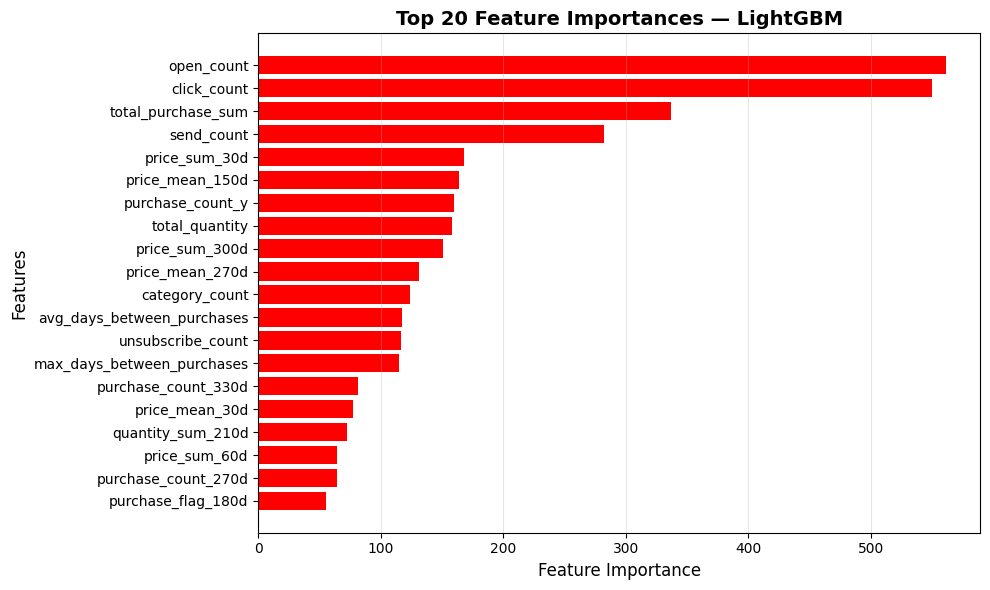


2. SHAP VALUES
Вычисление SHAP для LightGBM...


100%|===================| 39778/39879 [03:15<00:00]        


Топ-20 признаков по SHAP:
                   feature  mean_abs_shap
               click_count       0.337419
                open_count       0.164656
          purchase_count_y       0.106746
max_days_between_purchases       0.086776
            total_quantity       0.075512
        total_purchase_sum       0.069274
avg_days_between_purchases       0.065969
        quantity_mean_360d       0.059203
           price_mean_150d       0.058811
                send_count       0.055028
            category_count       0.054581
         unsubscribe_count       0.054383
        purchase_flag_180d       0.045412
       purchase_count_330d       0.039810
            price_sum_300d       0.037868
         quantity_sum_210d       0.034045
           price_mean_270d       0.033165
        quantity_mean_120d       0.032499
         quantity_sum_150d       0.020170
             price_sum_30d       0.013999


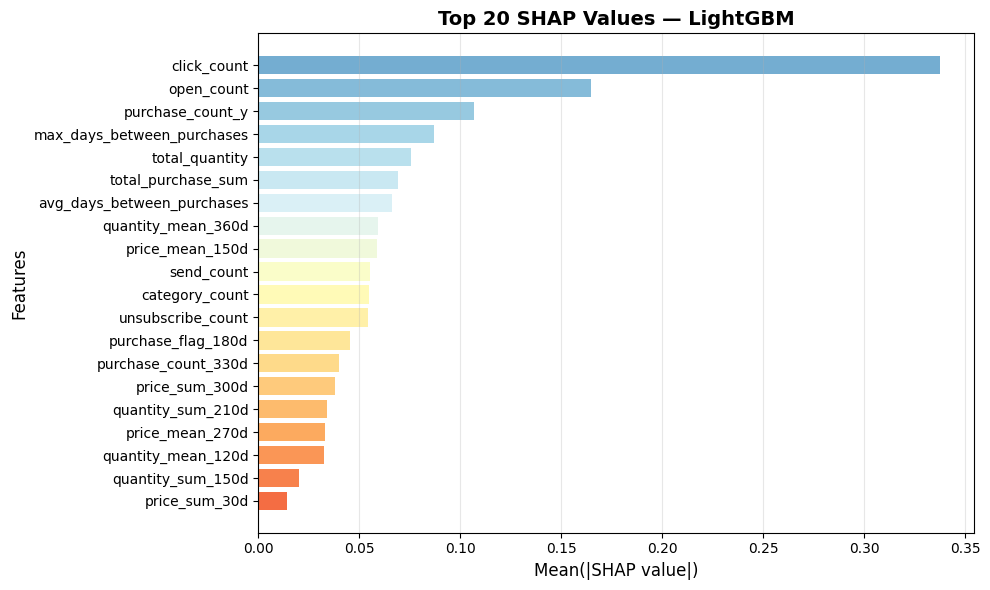


Построение SHAP Beeswarm Plot...


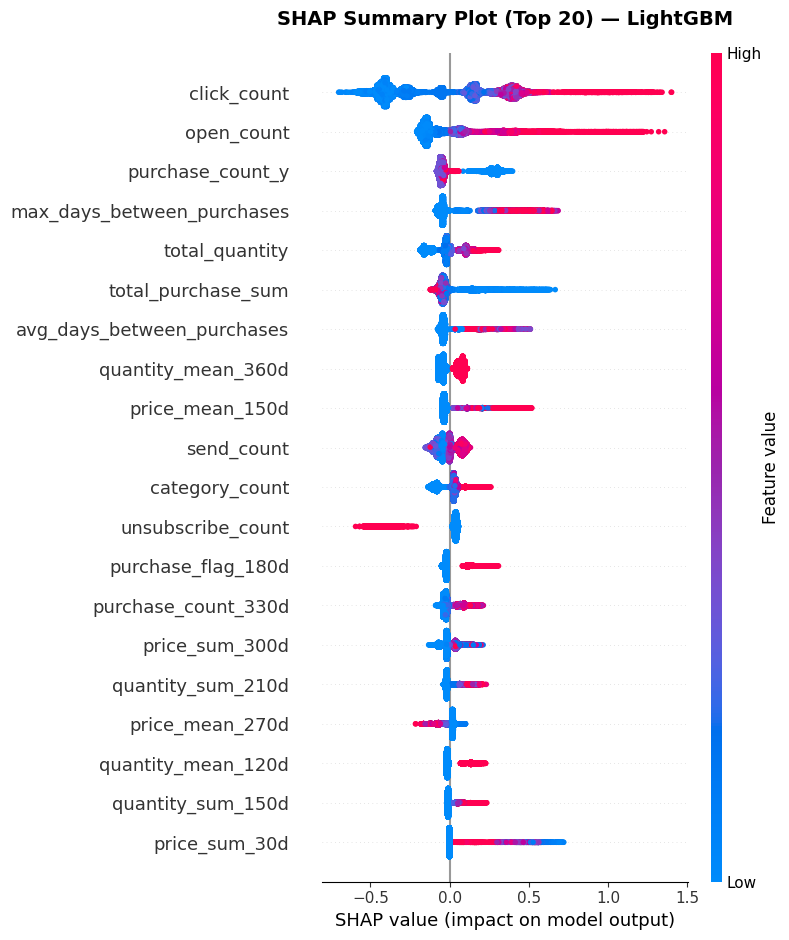


3. PERMUTATION IMPORTANCE
Вычисление Permutation Importance...

Топ-20 признаков по Permutation Importance:
                   feature  importance      std
          purchase_count_y    0.025201 0.002260
        total_purchase_sum    0.011463 0.000890
                send_count    0.011401 0.001554
max_days_between_purchases    0.006566 0.001107
            total_quantity    0.004872 0.001572
        quantity_mean_300d    0.004396 0.001302
             price_sum_30d    0.004181 0.001761
       purchase_count_270d    0.003393 0.000651
         quantity_sum_150d    0.003194 0.001322
avg_days_between_purchases    0.003149 0.000869
               click_count    0.002984 0.001326
            price_mean_30d    0.002074 0.000827
            price_sum_300d    0.000623 0.000316
        purchase_flag_180d    0.000546 0.000492
        quantity_mean_240d    0.000504 0.000664
        purchase_count_90d    0.000460 0.000090
        purchase_count_30d    0.000400 0.000353
       purchase_count_330d 

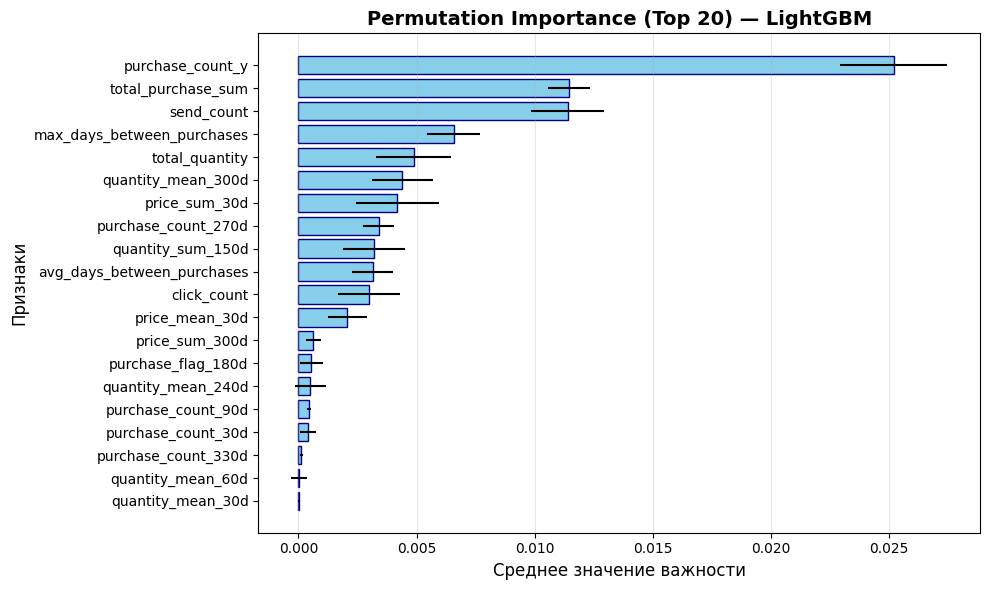


АНАЛИЗ ЗАВЕРШЕН


In [152]:

analysis_results = analyze_best_model(
    optuna_results=optuna_results,
    optuna_results_df=optuna_results_df,
    df_cleaned=df_cleaned,
    X_train=X_train,
    y_train=y_train,
    # TOP_N: количество самых важных признаков для сохранения
    # Значение 20: выбираем 20 самых влиятельных признаков
    # Результат: упрощение модели, ускорение обучения
    top_n=TOP_N
)

Вывод:  
● Изучены данные  
● Разработаны полезные признаки  
● Созданы модели для классификации пользователей  
● Улучшены модель и максимизирована метрику roc_auc  
● Проведено тестирование    

В итоговой итерации доработаны гиперпараметры, чтобы бороться с переобучением на тестовой выборке  

Лучшая модель: LightGBM  
Train ROC AUC: 0.7840  
Test ROC AUC: 0.7617